In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import warnings
from stocker import Stocker
warnings.simplefilter('ignore')

# Лабораторная работа №1. 

 рынок: <b>Китай</b><br>
 период: <b>2018 год</b>

Седунов Илья, <br>
Альперович Вадим, <br>
Славутин Александр,<br>
17ПМИ.

<b> 1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка.

In [ ]:
# c помщью парсинга yahoo! finance получаем первые 2500 активов с оъемом продаж за день больше 5 000 000$

# $ python stock_spider.py

df = pd.read_excel('data/china_stocks.xlsx')
df = df.drop_duplicates(['Symbol'])
symbols = list(df['Symbol'])
print('China ticker symbols = ', len(symbols))

China ticker symbols =  2500


In [ ]:
symbols[:5]

['000725.SZ', '300185.SZ', '601216.SS', '002617.SZ', '600221.SS']

In [ ]:
# скачиваем исторические данные для полученных активов за 2018 год 

start = "2018-01-01"
end   = "2018-12-31"
stocks = {}

for symbol in tqdm_notebook(symbols):
    stocks[symbol] = yf.download(symbol, start=start, end=end, progress=False)

In [ ]:
print('Исторические данные для актива', symbols[120])
stocks[symbols[120]].head()

Исторические данные для актива 300139.SZ


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,7.89,7.94,7.85,7.90,7.90,1984719
2018-01-03,7.91,7.97,7.86,7.96,7.96,2631433
2018-01-04,7.96,7.98,7.84,7.91,7.91,2543300
2018-01-05,7.90,7.92,7.84,7.87,7.87,2259400
2018-01-08,7.88,7.88,7.72,7.80,7.80,2157856


**Загрузим данные индекса SSE 50** <br>
*SSE 50 – второй по популярности фондовый индекс Шанхайской биржи (после SSE Composite), отображающий среднеарифметическую цену 50 крупнейших предприятий Китая. Часто SSE 50 так и называют - индексом "голубых фишек" SSE.*

In [ ]:
sse_components = pd.read_csv('data/SSE50.csv', names=['name', 'industry','symbol'])
sse50 = yf.download('^SSE50', start=start, end=end, progress=False)
sse50.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2867.530029,2912.270020,2867.530029,2908.729980,2908.729980,54000
2018-01-03,2914.280029,2947.629883,2906.600098,2913.260010,2913.260010,48200
2018-01-04,2918.260010,2934.149902,2910.659912,2919.479980,2919.479980,43500
2018-01-05,2926.780029,2940.179932,2920.080078,2932.360107,2932.360107,49900
2018-01-08,2933.820068,2952.340088,2926.870117,2947.760010,2947.760010,58100


<b>2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

In [ ]:
def get_descriptive_statistics(frame):
    E = frame["log_return"].mean()
    sigma = frame["log_return"].std()
    frame['E'] = E
    frame['Sigma'] = sigma
    return frame, E, sigma

def get_return(frame):
    frame['return'] = frame['Close'] / frame['Close'].shift(1)
    frame['log_return'] = np.log(frame['return'])
    return frame

stock_stat = pd.DataFrame(columns=['symbol',  'E', 'Sigma', 'mean_vol', 'mean_return', 'mean_log_return'])

for symbol in tqdm_notebook(symbols):
    stock = get_return(stocks[symbol])
    stock, E, Sigma = get_descriptive_statistics(stock)
    stock_stat.loc[symbol] = [symbol,
                               E,
                               Sigma, 
                               stock['Volume'].mean(), 
                               stock['return'].mean(), 
                               stock['log_return'].mean()]

In [ ]:
stock_stat.dropna(inplace=True)
print('Осталось активов после обработки', len(stock_stat))
stock_stat.head()

Осталось активов после обработки 2389


,symbol,E,Sigma,mean_vol,mean_return,mean_log_return
000725.SZ,000725.SZ,-0.003218,0.024556,5.327386e+08,0.997086,-0.003218
300185.SZ,300185.SZ,-0.001474,0.016357,1.643139e+07,0.998659,-0.001474
601216.SS,601216.SS,-0.002424,0.017379,1.890479e+07,0.997728,-0.002424
002617.SZ,002617.SZ,-0.004140,0.021047,1.050691e+07,0.996084,-0.004140
600221.SS,600221.SS,-0.002185,0.019393,3.198766e+07,0.997997,-0.002185


<Figure size 1152x576 with 0 Axes>

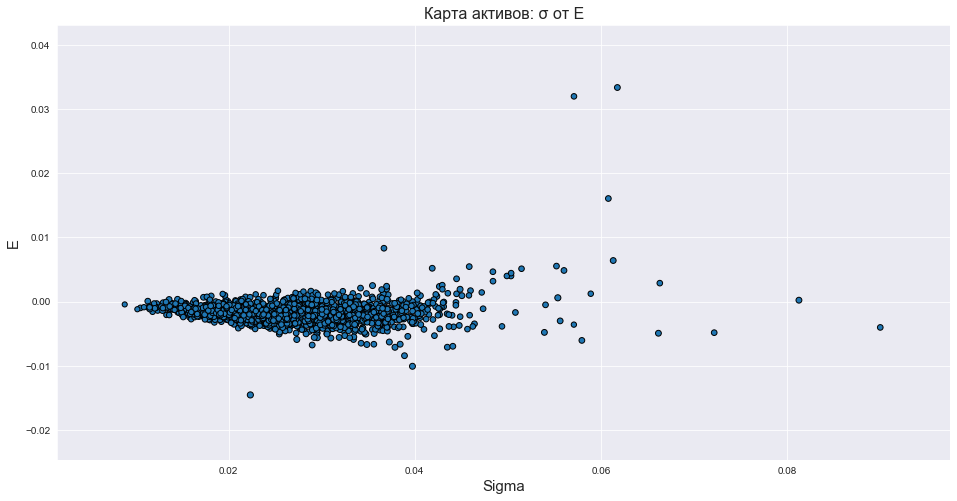

In [ ]:
import seaborn as sns
from seaborn import set_style
set_style('dark')
plt.figure(figsize=(16, 8))
ax = stock_stat.plot(x='Sigma', y='E', s=np.log(stock_stat['mean_vol'])*2.0, 
                      kind='scatter', 
                      figsize=(16, 8), 
                      edgecolor='black',
                      grid=True)
plt.xlabel('Sigma', size=15)
plt.ylabel('E', size=15)
plt.title("Карта активов: σ от E", size=16)
pass

**Комментарий:** по карте активов можем отметить четкую границу эффективного множества, а также можем заметить точку с наименьшей дисперсией (ТНД).

<b>3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат (σ, E). Дайте характеристику этому портфелю.



In [ ]:
portfolio = pd.DataFrame.from_dict({'date':stocks[symbols[0]].index})
for symbol in symbols:
    try:
        portfolio[symbol] = list(stocks[symbol]['return'])
    except Exception as e:
        continue
portfolio = portfolio.dropna()
portfolio = portfolio.set_index('date')

In [ ]:
portfolio['balanced_return']     = portfolio.mean(axis=1)
portfolio['balanced_log_return'] = np.log(portfolio['balanced_return'])

In [ ]:
balancedp = dict(symbol=['balanced_portfolio'],
                 E=[portfolio['balanced_log_return'].mean()],
                 Sigma=[portfolio['balanced_log_return'].std()],
                 mean_vol=[stock_stat['mean_vol'].mean()],
                 mean_return=[portfolio['balanced_return'].mean()],
                 mean_log_return=[portfolio['balanced_log_return'].mean()])
balancedp = pd.DataFrame.from_dict(balancedp)
balancedp.index = ['balanced_portfolio']
stock_stat = stock_stat.append(balancedp)
stock_stat.tail()

,symbol,E,Sigma,mean_vol,mean_return,mean_log_return
002190.SZ,002190.SZ,-0.001221,0.030015,4.194268e+06,0.999228,-0.001221
300724.SZ,300724.SZ,0.003555,0.044484,1.338313e+07,1.004540,0.003555
300634.SZ,300634.SZ,0.004437,0.050346,6.334249e+06,1.005713,0.004437
603133.SS,603133.SS,-0.003106,0.030696,2.419736e+06,0.997365,-0.003106
balanced_portfolio,balanced_portfolio,-0.001540,0.015532,1.271112e+07,0.998581,-0.001540


<Figure size 1152x576 with 0 Axes>

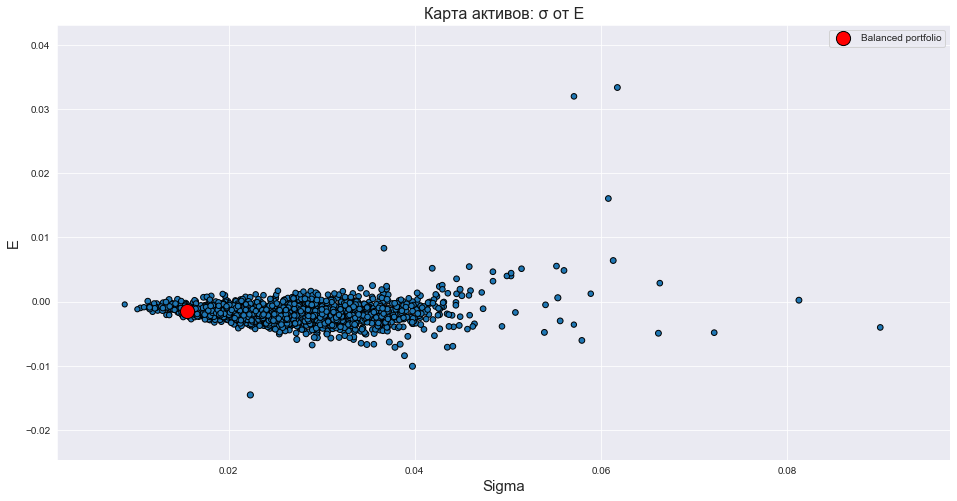

In [ ]:
plt.figure(figsize=(16, 8))
ax = stock_stat.plot(x='Sigma', y='E', s=np.log(stock_stat['mean_vol'])*2.0, 
                      kind='scatter', 
                      figsize=(16, 8), 
                      edgecolor='black')
balancedp.plot(x='Sigma', y='E', s=200, kind='scatter',  
               edgecolor='black',  
               grid=True, 
               c='red', 
               ax=ax, 
               label='Balanced portfolio')
plt.xlabel('Sigma', size=15)
plt.ylabel('E', size=15)
plt.title("Карта активов: σ от E", size=16)
plt.show()

In [ ]:
print('Средняя доходность %.4f, стд. отклонение %.4f' % (stock_stat[stock_stat.index == 'balanced_portfolio']['E'], 
stock_stat[stock_stat.index == 'balanced_portfolio']['Sigma']))

Средняя доходность -0.0015, стд. отклонение 0.0155


**Комментарий**: <br>Сбалансированный портфель представляет собой среднеарифметическое по доходностям (ценам) всех собранных активов (~2500). Можно отметить, что посчитанный сбалансированный портфель имеет отрицательную среднюю доходность, что говорит о в падении цен активов на Китайском рынке за период 2018 года. Однако, сбалансированный портфель обладает риском практически приближенным к ТНД благодаря успешной диверсификации.

<b>4. Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E). Дайте характеристику индексу рынка.

In [ ]:
sse50 = get_return(sse50)
sse50_stat = dict(symbol=['sse50'],
                 E=[sse50['log_return'].mean()],
                 Sigma=[sse50['log_return'].std()],
                 mean_vol=[sse50['Volume'].mean()],
                 mean_return=[sse50['return'].mean()],
                 mean_log_return=[sse50['log_return'].mean()])

sse50_stat = pd.DataFrame.from_dict(sse50_stat)
sse50_stat.index = ['sse50']
stock_stat = stock_stat.append(sse50_stat)
stock_stat.tail()

,symbol,E,Sigma,mean_vol,mean_return,mean_log_return
300724.SZ,300724.SZ,0.003555,0.044484,1.338313e+07,1.004540,0.003555
300634.SZ,300634.SZ,0.004437,0.050346,6.334249e+06,1.005713,0.004437
603133.SS,603133.SS,-0.003106,0.030696,2.419736e+06,0.997365,-0.003106
balanced_portfolio,balanced_portfolio,-0.001540,0.015532,1.271112e+07,0.998581,-0.001540
sse50,sse50,-0.000983,0.013850,4.140000e+04,0.999113,-0.000983


<Figure size 1152x576 with 0 Axes>

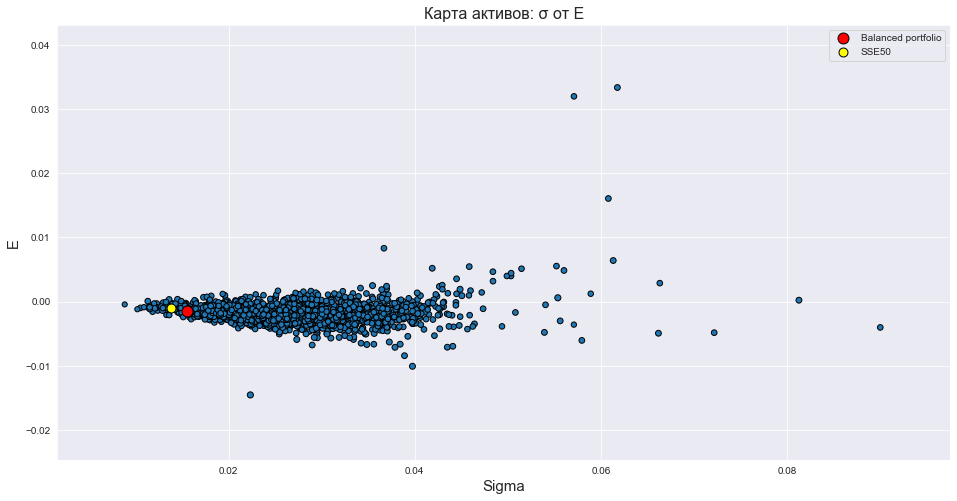

In [ ]:
plt.figure(figsize=(16, 8))
ax = stock_stat.plot(x='Sigma', y='E', s=np.log(stock_stat['mean_vol'])*2.0, 
                      kind='scatter', 
                      figsize=(16, 8), 
                      edgecolor='black')
balancedp.plot(x='Sigma', y='E', s=120, kind='scatter',  
               edgecolor='black',  
               grid=True, 
               c='red', 
               ax=ax, 
               label='Balanced portfolio')
sse50_stat.plot(x='Sigma', y='E', s=80, kind='scatter',  
               edgecolor='black',  
               grid=True, 
               c='yellow', 
               ax=ax, 
               label='SSE50')
plt.xlabel('Sigma', size=15)
plt.ylabel('E', size=15)
plt.title("Карта активов: σ от E", size=16)
pass

In [ ]:
print('Средняя доходность %.4f, стд. отклонение %.4f' % (stock_stat[stock_stat.index == 'sse50']['E'], 
stock_stat[stock_stat.index == 'sse50']['Sigma']))

Средняя доходность -0.0010, стд. отклонение 0.0139


**Комментарий**:<br>  SSE 50 – второй по популярности фондовый индекс Шанхайской биржи (после SSE Composite), отображающий среднеарифметическую цену 50 крупнейших предприятий Китая. Часто SSE 50 так и называют - индексом "голубых фишек" SSE. По карте активов можем отметить, что SSE50 обладает меньшим риском, относительно сбалансированнного портфеля, и более высокой доходностью, что может быть объяснимо характеристикой его компонент. Однако, SSE50 все же очень близок к сбалансированному портфелю, соотвественно он хорошо отражает усредненную ситуацию на Китайском рынке.

<b>5. Задайте уровень риска и оцените VaR (Value at Risk = Сумма под Риском) для активов вашего рынка. Какой из активов наиболее предпочтителен по этой характеристике? Где он расположен на карте активов? Дайте характеристику VaR портфеля с равными долями и индекса рынка.

In [ ]:
from scipy import stats

print('Всего %d рассматриваемых активов' % (len(stock_stat.index)))
print('Используем тест Шапиров-Вилка на нормальность распределения')
print('Выведем акции, для которых гипотеза о нормальности не отвергается с уровнем доверия 0.05 \n')

for symbol in stock_stat.index[:-2]:
    sample = stocks[symbol]
    if len(sample) > 50:
        stat, p= stats.shapiro(sample['log_return'].iloc[1:])
        if p > 0.049:
            print('Для %s: **Statistics=%.3f, p-value=%.3f**' % (symbol, stat, p))

Всего 2391 рассматриваемых активов
Используем тест Шапиров-Вилка на нормальность распределения
Выведем акции, для которых гипотеза о нормальности не отвергается с уровнем доверия 0.05 

Для 300296.SZ: **Statistics=0.990, p-value=0.098**
Для 601318.SS: **Statistics=0.992, p-value=0.248**
Для 000002.SZ: **Statistics=0.989, p-value=0.055**
Для 002531.SZ: **Statistics=0.990, p-value=0.091**
Для 600019.SS: **Statistics=0.991, p-value=0.149**
Для 300373.SZ: **Statistics=0.995, p-value=0.604**
Для 603025.SS: **Statistics=0.990, p-value=0.105**
Для 600276.SS: **Statistics=0.992, p-value=0.244**
Для 600196.SS: **Statistics=0.996, p-value=0.745**
Для 600893.SS: **Statistics=0.990, p-value=0.096**
Для 300232.SZ: **Statistics=0.990, p-value=0.092**
Для 000540.SZ: **Statistics=1.000, p-value=1.000**
Для 300398.SZ: **Statistics=0.989, p-value=0.058**
Для 002050.SZ: **Statistics=0.989, p-value=0.056**
Для 601601.SS: **Statistics=0.990, p-value=0.087**
Для 002332.SZ: **Statistics=0.994, p-value=0.513*

In [ ]:
chosen_asset = '300373.SZ'
sample = stocks[chosen_asset]
stat, p= stats.shapiro(sample['log_return'].iloc[1:])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=0.995, p-value=0.604


In [ ]:
sample['log_return'].describe()

count    242.000000
mean      -0.003021
std        0.032959
min       -0.105488
25%       -0.024048
50%       -0.005165
75%        0.017501
max        0.084599
Name: log_return, dtype: float64

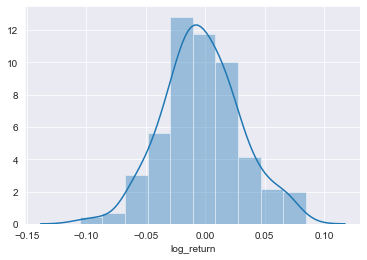

In [ ]:
import seaborn as sns
plt.grid()
sns.distplot(sample['log_return'], bins=10)
plt.show()

**1.  Variance-Covariance подход**

In [ ]:
stock_stat = stock_stat.dropna()

In [ ]:
from scipy.stats import norm

confidence_lvl = [0.9, 0.95, 0.99]

VaR = {}

print('VaR характеристика для %s:' % chosen_asset)
for clvl in confidence_lvl:
    VaR[clvl] = -norm.ppf(1-clvl, sample['log_return'].mean(), sample['log_return'].std())
    print(' - Потери не превысят %.4f с %.2f%s уверенностью.' % (VaR[clvl], clvl, '%'))

VaR характеристика для 300373.SZ:
 - Потери не превысят 0.0453 с 0.90% уверенностью.
 - Потери не превысят 0.0572 с 0.95% уверенностью.
 - Потери не превысят 0.0797 с 0.99% уверенностью.


Покажем на графике распределения значения VaR характеристики:

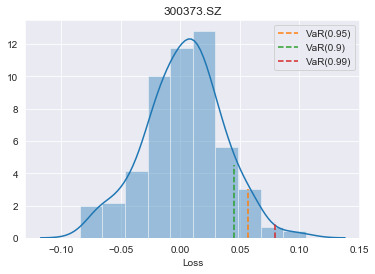

In [ ]:
import seaborn as sns               

plt.grid()
sns.distplot(-sample['log_return'], bins=10)
 
plt.plot([VaR[0.95],VaR[0.95]],[0,3], '--', label='VaR(0.95)')
plt.plot([VaR[0.9],VaR[0.9]],[0,4.5], '--', label='VaR(0.9)')
plt.plot([VaR[0.99],VaR[0.99]],[0,1], '--', label='VaR(0.99)')
plt.legend()
plt.xlabel('Loss')
plt.title(chosen_asset)
plt.show()

**Комментарий**: 
1. Итак, видим, что для того, чтобы рассчитать VaR методом Variance-Covariance достаточно использовать point percentile function (ppf) нормального распределения, которая посчитая нам по заданной вероятности точку на оси абсцисс графика нормального распределения с заданными средним и дисперсией (полученными по выборке).
2. Более подробное объяснение есть в [Методы-и-алгоритмы-финансовой-математики](https://vk.com/doc136761433_569070591?hash=bfb7543c4fc46de90d&dl=8a67bf04c0efe170cd) на стр. **599**

In [ ]:
stock_stat = stock_stat.drop_duplicates()

In [ ]:
# посчитаем VaR для всех активов (данным методом), предполагая, что они нормально распределены

for symbol in stock_stat.index[:-2]:
    sample = stocks[symbol]
    for clvl in confidence_lvl:
        stock_stat.at[symbol, 'VaR_'+str(clvl)] = -norm.ppf(1-clvl, 
                                                                sample['log_return'].mean(), 
                                                                sample['log_return'].std())

In [ ]:
# получим самые привлекательные активы, основываясь на VaR (у них наименьшие предполагаемые потери)

stock_stat.dropna().sort_values(['VaR_0.95'], ascending=[True]).head()

,symbol,E,Sigma,mean_vol,mean_return,mean_log_return,VaR_0.9,VaR_0.95,VaR_0.99
300280.SZ,300280.SZ,-0.000439,0.008846,4.848308e+05,0.999601,-0.000439,0.011775,0.014988,0.021016
000534.SZ,000534.SZ,-0.001189,0.010203,7.288091e+05,0.998864,-0.001189,0.014265,0.017972,0.024925
600811.SS,600811.SS,-0.000980,0.010532,7.993391e+06,0.999075,-0.000980,0.014477,0.018303,0.025481
600900.SS,600900.SS,0.000063,0.011326,1.843271e+07,1.000127,0.000063,0.014451,0.018566,0.026285
002412.SZ,002412.SZ,-0.000872,0.010913,1.583296e+06,0.999187,-0.000872,0.014858,0.018823,0.026260


**2. Подход исторических данных**

подход заключается в следующем: 
 1. Вычисляем доходности 
 2. Сортируем доходности от худшего к лучшему
 3. Вычисляем кумулятивную функцию
  <br> *=>* VaR с 90% уровнем это 10%<br>
  
*Или просто вычисляем 10% квантиль*

In [ ]:
sample = stocks[chosen_asset]
sample = sample.sort_values(['log_return'], ascending=[True]).dropna()

In [ ]:
print('VaR характеристика для %s:' % chosen_asset)
for clvl in confidence_lvl:
    VaR[clvl] = -sample.log_return.quantile(1-clvl)
    print(' - Потери не превысят %.4f с %.2f%s уверенностью.' % (VaR[clvl], clvl, '%'))

VaR характеристика для 300373.SZ:
 - Потери не превысят 0.0428 с 0.90% уверенностью.
 - Потери не превысят 0.0580 с 0.95% уверенностью.
 - Потери не превысят 0.0796 с 0.99% уверенностью.


**Замечание**: 
    1. Как вы можете увидеть здесь есть НЕзначительная разница между посчитанными VaR по методу двум методам 
    2. Значительная разница может говорить о том, что распределение не нормальное.

In [ ]:
# посчитаем VaR для всех активов (данным методом)

for symbol in symbols:
    sample = stocks[symbol]
    sample = sample.sort_values(['log_return'], ascending=[True]).dropna()
    for clvl in confidence_lvl:
        stock_stat.at[symbol, 'qVaR_'+str(clvl)] = -sample.log_return.quantile(1-clvl)

In [ ]:
stock_stat.dropna(inplace=True)
stock_stat.sort_values(['qVaR_0.95'], ascending=[True]).head(10)

,symbol,E,Sigma,mean_vol,mean_return,mean_log_return,VaR_0.9,VaR_0.95,VaR_0.99,qVaR_0.9,qVaR_0.95,qVaR_0.99
000912.SZ,000912.SZ,-0.000755,0.011537,5.451515e+05,0.999311,-0.000755,0.015540,0.019732,0.027594,-0.000000,-0.000000,0.051387
600399.SS,600399.SS,-0.003587,0.057083,1.306536e+06,0.997654,-0.003587,0.076742,0.097480,0.136382,-0.000000,-0.000000,0.014693
002252.SZ,002252.SZ,-0.003729,0.023759,6.288275e+06,0.996552,-0.003729,0.034177,0.042809,0.059000,0.001018,0.008074,0.105565
300280.SZ,300280.SZ,-0.000439,0.008846,4.848308e+05,0.999601,-0.000439,0.011775,0.014988,0.021016,0.005873,0.009599,0.016540
300087.SZ,300087.SZ,-0.000280,0.011997,1.271574e+06,0.999791,-0.000280,0.015655,0.020014,0.028190,0.010509,0.013916,0.028766
603158.SS,603158.SS,-0.000503,0.014286,5.422557e+05,0.999598,-0.000503,0.018811,0.024001,0.033737,0.011275,0.014997,0.042709
000534.SZ,000534.SZ,-0.001189,0.010203,7.288091e+05,0.998864,-0.001189,0.014265,0.017972,0.024925,0.009855,0.016064,0.035138
002739.SZ,002739.SZ,-0.001914,0.016558,3.068663e+06,0.998221,-0.001914,0.023134,0.029150,0.040434,-0.000000,0.016091,0.105384
600811.SS,600811.SS,-0.000980,0.010532,7.993391e+06,0.999075,-0.000980,0.014477,0.018303,0.025481,0.009534,0.016197,0.042329
600642.SS,600642.SS,-0.000791,0.011439,8.053353e+06,0.999274,-0.000791,0.015451,0.019607,0.027402,0.010651,0.016752,0.039016


**Комментарий**:
- заметим, что наилучшей метрикой VaR при уровне доверия 95% обладают активы  Отобразим их на карте активов:

<Figure size 1152x576 with 0 Axes>

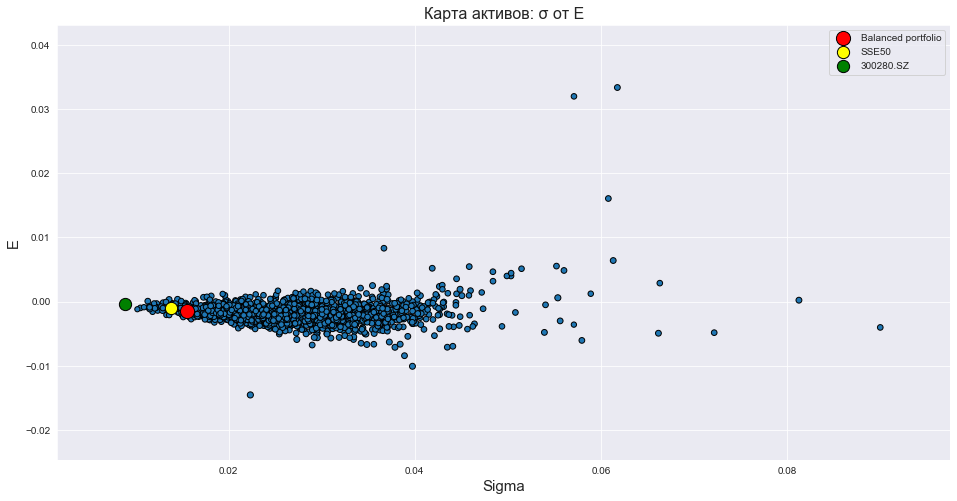

In [ ]:
chosen_var_active = '300280.SZ' #'000912.SZ'
best_VaR = [chosen_var_active]

plt.figure(figsize=(16, 8))
ax = stock_stat.plot(x='Sigma', y='E', s=np.log(stock_stat['mean_vol'])*2.0, 
                      kind='scatter', 
                      figsize=(16, 8), 
                      edgecolor='black')
balancedp.plot(x='Sigma', y='E', s=200, kind='scatter',  
               edgecolor='black',  
               grid=True, 
               c='red', 
               ax=ax, 
               label='Balanced portfolio')
sse50_stat.plot(x='Sigma', y='E', s=150, kind='scatter',  
               edgecolor='black',  
               grid=True, 
               c='yellow', 
               ax=ax, 
               label='SSE50')

for bestsym in best_VaR:
    stock_stat[stock_stat.index==bestsym].plot(x='Sigma', y='E', s=150, kind='scatter',  
                   edgecolor='black',  
                   grid=True, 
                   c='green', 
                   ax=ax, 
                   label=bestsym)
    
plt.xlabel('Sigma', size=15)
plt.ylabel('E', size=15)
plt.title("Карта активов: σ от E", size=16)
pass

In [ ]:
print('Средняя доходность %.4f, стд. отклонение %.4f' % (stock_stat[stock_stat.index == chosen_var_active]['E'], 
stock_stat[stock_stat.index == chosen_var_active]['Sigma']))

Средняя доходность -0.0004, стд. отклонение 0.0088


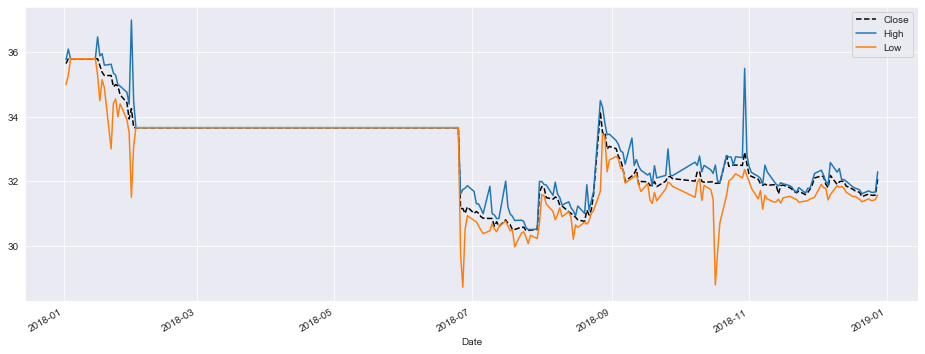

In [ ]:
ax = stocks[chosen_var_active].plot(y='Close', grid=True, figsize=(16,6), style='k--')
stocks[chosen_var_active].plot(y='High', grid=True, figsize=(16,6), ax=ax)
stocks[chosen_var_active].plot(y='Low', grid=True, figsize=(16,6), ax=ax)
plt.show()

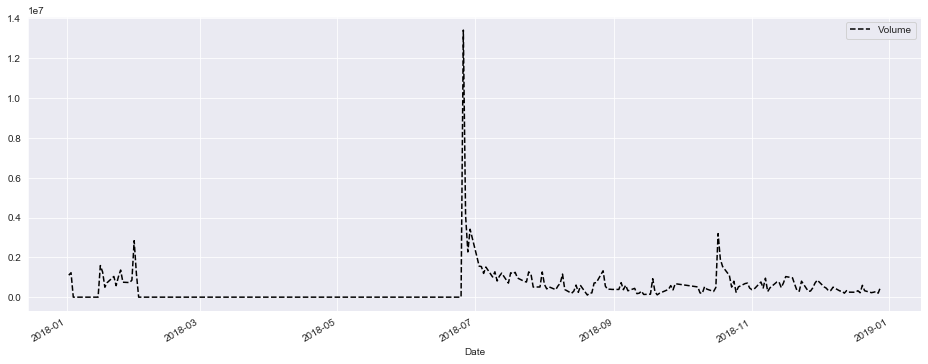

In [ ]:
stocks[chosen_var_active].plot(y='Volume', grid=True, figsize=(16,6), style='k--')

**Комментарий**:<br> Наилучший по характеристике Суммы под Риском актив 000912.SZ (Sichuan Lutianhua Company Limited) находится на карте активов практически в точке ТНД. Также стоит отметить, что цены этого актива практически на протяжении всего 2018 года были фиксированы.

#### Характеристика VaR для портфеля с равными долями и индекса рынка

Сбалансированный портфель:

In [ ]:
print('VaR характеристика для сбалансированного портфеля (основано на %d активах):' % (len(portfolio.columns)-2))
portfolio = portfolio.sort_values(['balanced_log_return'], ascending=[True]).dropna()
for clvl in confidence_lvl:
    VaR[clvl] = -portfolio.balanced_log_return.quantile(1-clvl)
    print(' - Потери не превысят %.4f с %.2f%s уверенностью.' % (VaR[clvl], clvl, '%'))

VaR характеристика для сбалансированного портфеля (основано на 2339 активах):
 - Потери не превысят 0.0193 с 0.90% уверенностью.
 - Потери не превысят 0.0254 с 0.95% уверенностью.
 - Потери не превысят 0.0526 с 0.99% уверенностью.


Индекс рынка SSE50:

In [ ]:
print('VaR характеристика для индекса SSE50:')
sse50 = sse50.sort_values(['log_return'], ascending=[True]).dropna()
for clvl in confidence_lvl:
    VaR[clvl] = -sse50.log_return.quantile(1-clvl)
    print(' - Потери не превысят %.4f с %.2f%s уверенностью.' % (VaR[clvl], clvl, '%'))

VaR характеристика для индекса SSE50:
 - Потери не превысят 0.0182 с 0.90% уверенностью.
 - Потери не превысят 0.0239 с 0.95% уверенностью.
 - Потери не превысят 0.0408 с 0.99% уверенностью.


In [ ]:
print('Средний VaR %.4f Медиана VaR %.4f c 0.95 уверенностью' % (stock_stat['qVaR_0.95'].mean(), 
                                                                   stock_stat['qVaR_0.95'].median()))

Средний VaR 0.0442 Медиана VaR 0.0428 c 0.95 уверенностью


**Комментарий**:<br>Можно отметить, что по характеристике Сумма под Риском индекс SSE50 является приоритетнее сбалансированного портфеля.

<b>6. Выберите несколько интересных (значимых) активов рынка. Можно ли считать наблюдаемые доходности (объемы продаж) конкретного актива повторной выборкой из некоторого распределения (белый шум)? 

In [ ]:
sse_stat = pd.DataFrame(columns=['sigma', 'E', 'names', 'mean_vol', 'mean_log_return', 'industry'])
sse_stocks = {}

for index, row in tqdm_notebook(sse_components.iterrows()):
    name, industry, symbol = row
    if (name != 'Index' and name != 'Bank of China Limited'):
        symbol = str(symbol) + '.SS'
    sse_stock = yf.download(symbol, start="2018-01-01", end="2018-12-31", progress=False)
    sse_stock = get_return(sse_stock)
    sse_stock, E, s = get_descriptive_statistics(sse_stock)
    mean_vol = sse_stock['Volume'].mean()
    sse_stocks[industry+'/'+name] = sse_stock
        
    sse_stat.loc[index] = [s, E, name, mean_vol, sse_stock['log_return'].mean(), industry]

In [ ]:
stocks_names = ['Banking/Bank of Jiangsu', 
                'Automotive/SAIC Motor', 
                'Construction/China Railway Construction', 
                'Oil & gas/PetroChina',
                'Telecommunication/China United Network Communications']

#### **Гипотеза о случайности.**
В различных статистических задачах исходные данные $X = (X_1, ..., X_n)$ часто рассматривают случайную выборку из некоторого распределения $\beta(\sigma)$, то есть считают компоненты  $X_i$ вектора данных $X$ независимыми и одинаково распредленными случайными величинами. <br><br>
Такая гипотеза называется **гипотезой случайности** и записывается в виде:<br><br>
<center>$H_0 -    F_X(x_1,...,x_n) = F(x_1), ..., F(x_n)$, <br>
где $F(x)$ - некоторая одномерная функция распределения.                                                 

#### Критерий инверсий

Инверсия имеет место, если в выборке значений $x_1,...,x_n$ записанных в порядке их появления, за некоторым значением  $x_i$ следует меньшее по величине, т.е. $x_i > x_j$, где $i<j<=n$. Статистикой критерия случайности является общеечисло инверсий $I$ в выборке $x_1,...,x_n$

Гипотеза о случайности не отклоняется, если $I_\alpha < I < I_1-\alpha/2$. Возможное количество инверсий зависит от объема выборки. Математическое ожидание и дисперсия статистики $I$ имеют вид $E[I] = \frac {n(n-1)}{4}$, $D[I] = \frac{(2n^3 + 3n^2 - 5n)}{72}$

Нормализованная статистика: $I^* = \frac{I - E[I]}{D[I]^{1/2}}$

Гипотеза $H_0$ отклоняется при больших по модулю значениях статистики $|I^*| >= U_{1-\alpha/2}$

In [ ]:
def mergeSort(arr, n): 
    temp_arr = [0]*n 
    return _mergeSort(arr, temp_arr, 0, n-1) 

def _mergeSort(arr, temp_arr, left, right): 
    inv_count = 0
    if left < right:
        mid = (left + right)//2
        inv_count += _mergeSort(arr, temp_arr, left, mid) 
        inv_count += _mergeSort(arr, temp_arr, mid + 1, right)
        inv_count += merge(arr, temp_arr, left, mid, right) 
    return inv_count

def merge(arr, temp_arr, left, mid, right): 
    i = left    
    j = mid + 1 
    k = left     
    inv_count = 0
    while i <= mid and j <= right: 
        if arr[i] <= arr[j]: 
            temp_arr[k] = arr[i] 
            k += 1
            i += 1
        else: 
            # Инверсия
            temp_arr[k] = arr[j] 
            inv_count += (mid-i + 1) 
            k += 1
            j += 1
    while i <= mid: 
        temp_arr[k] = arr[i] 
        k += 1
        i += 1
    while j <= right: 
        temp_arr[k] = arr[j] 
        k += 1
        j += 1
    for loop_var in range(left, right + 1): 
        arr[loop_var] = temp_arr[loop_var] 
          
    return inv_count 

def inversion_test(stock, alpha, column):
    cleaned_stock = stock[column].dropna()
    n = len(cleaned_stock)
    inv_amount = mergeSort(cleaned_stock, n) # число инверсий в данных, инверсия - когда i < j , а arr[i] > arr[j]
    inv_amount_expectation = (n*(n-1)) / 4
    inv_amount_variance = (n*(n-1)*(2*n+5)) / 72
    normalized_inv_statistic = (inv_amount - inv_amount_expectation)/(inv_amount_variance**(1/2))
    return abs(normalized_inv_statistic) >= stats.norm.ppf(1 - alpha/2)

In [ ]:
start = "\033[1m"
end = "\033[0;0m"
alpha = 0.05
to_rus = {'log_return': 'доходности', 'Volume': 'объема продаж'}
print('Критерий инверсии:\n')
for label in stocks_names:
    stock = sse_stocks[label]
    for column in ['log_return','Volume']:
        if inversion_test(stock, alpha, column):
            print(f'Г-за случайности \"{label}\" для {to_rus[column]} {start}отвергается{end}')
        else:
            print(f'Г-за случайности \"{label}\" для {to_rus[column]} {start}принимается{end}')
    print()

Критерий инверсии:

Г-за случайности "Banking/Bank of Jiangsu" для доходности принимается
Г-за случайности "Banking/Bank of Jiangsu" для объема продаж отвергается

Г-за случайности "Automotive/SAIC Motor" для доходности принимается
Г-за случайности "Automotive/SAIC Motor" для объема продаж отвергается

Г-за случайности "Construction/China Railway Construction" для доходности принимается
Г-за случайности "Construction/China Railway Construction" для объема продаж отвергается

Г-за случайности "Oil & gas/PetroChina" для доходности принимается
Г-за случайности "Oil & gas/PetroChina" для объема продаж отвергается

Г-за случайности "Telecommunication/China United Network Communications" для доходности принимается
Г-за случайности "Telecommunication/China United Network Communications" для объема продаж отвергается




### Критерий автокорреляции

Если выборка $x_1, x_2, ..., x_n$ случайна, то значение каждого ее элемента не должно зависеть от величины предшествующего и последующего членов. Для проверки этой независимости используется статистика: 

$r_{1,n} = \frac{n\sum_{i=1}^{n-1} x_ix_{i+1}  -  (\sum_{i=1}^{n} x_i)^2 + nx_1x_n}{n\sum_{i=1}^{n}x_{i}^2 - (\sum_{i=1}^{n}x_{i})^2}$

При справедливости проверяемой гипотезы статистика $r_{1,n}$ распределена асимптотически нормально с математическим ожиданием и дисперсией

$E[r_{1,n}] = - \frac{1}{n-1}, D[r_{1,n}] = \frac{n(n-3)}{(n+1)(n-1)^2} $

Применяя критерий, обычно используют нормализованную статистику

$r_{1,n}^* = \frac{r_{1,n} - E[r_{1,n}]}{\sqrt{D[r_{1,n}]}}$

Гипотеза о случайности отклоняется при больших по модулю значениях статистики $r_{1,n}$ .

Математические нотации в коде:

$\sum_{i=1}^{n-1} x_ix_{i+1}$ - **sum_1**


$(\sum_{i=1}^{n} x_i)^2$  - **sum_2**

$\sum_{i=1}^{n}x_{i}^2$ - **sum_3**

In [ ]:
import math
def autocorrelation_test(stock, alpha, label, column):
    cleaned_stock = stock[column].dropna()
    n = len(cleaned_stock)
    sum_1 , sum_2 , sum_3 = 0, 0 , 0 
    for i in range(n - 1):
        sum_1 += cleaned_stock[i] * cleaned_stock[i+1]
    for i in range(n):
        sum_2 += cleaned_stock[i]
        sum_3 += cleaned_stock[i] * cleaned_stock[i]
    r_1_n = (n * sum_1  - sum_2 + n * cleaned_stock[0] * cleaned_stock[n-1])/ (n * sum_3 - sum_2)
    expexctation_r_1_n = - 1 / (n-1)
    variance_r_1_n = (n * (n-3)) / ((n+1) * (n-1)**2)
    r_1_n_normalized = (r_1_n - expexctation_r_1_n) / math.sqrt(variance_r_1_n)
    if abs(r_1_n_normalized) >= stats.norm.ppf(1 - alpha/2):
        print(f'Г-за случайности {label} {to_rus[column]} {start}отвергается{end} по критерию автокорреляции')
    else:
        print(f'Г-за случайности {label} {to_rus[column]} {start}принимается{end}  по критерию автокорреляции')
    #  Нормализующими преобразованиями статистики этого критерия являются статистики
    #  Морана , Люнга-Бокса  и Дюффа-Роя
    r_1_n_morang =  math.sqrt((n - 1)) * (n * r_1_n + 1) / (n - 2)
    
    # Статистика Морана
    if abs(r_1_n_morang) >= stats.norm.ppf(1 - alpha/2):
        print(f'Г-за случайности {label} {to_rus[column]} {start}отвергается{end} по критерию автокорреляции (со ст-кой Морана)')
    else:
        print(f'Г-за случайности {label} {to_rus[column]} {start}принимается{end}  по критерию автокорреляции (со ст-кой Морана)')
    
    # Статистика Люнга-Бокса
    
    r_1_n_lb = (n * (n + 2)/(n-1))**0.5 * r_1_n
    
    if abs(r_1_n_lb) >= stats.norm.ppf(1 - alpha/2):
        print(f'Г-за случайности {label} {to_rus[column]} {start}отвергается{end} по критерию автокорреляции (со ст-кой Люнга-Бокса)')
    else:
        print(f'Г-за случайности {label} {to_rus[column]} {start}принимается{end}  по критерию автокорреляции (со ст-кой Люнга-Бокса)')
        
    # Статистика Дюффа-Роя
    r_1_n_dr = ((n-1) / n * (n-2))**0.5 * (n * r_1_n + 1)
    
    if abs(r_1_n_dr) >= stats.norm.ppf(1 - alpha/2):
        print(f'Г-за случайности {label} {to_rus[column]} {start}отвергается{end} по критерию автокорреляции (со ст-кой Дюффа-Роя)')
    else:
        print(f'Г-за случайности {label} {to_rus[column]} {start}принимается{end}  по критерию автокорреляции (со ст-кой Дюффа-Роя)')
    
    

Г-за случайности Financial services/Huatai Securities доходности принимается  по критерию автокорреляции
Г-за случайности Financial services/Huatai Securities доходности принимается  по критерию автокорреляции (со ст-кой Морана)
Г-за случайности Financial services/Huatai Securities доходности принимается  по критерию автокорреляции (со ст-кой Люнга-Бокса)
Г-за случайности Financial services/Huatai Securities доходности отвергается по критерию автокорреляции (со ст-кой Дюффа-Роя)
Г-за случайности Financial services/Huatai Securities объема продаж отвергается по критерию автокорреляции
Г-за случайности Financial services/Huatai Securities объема продаж отвергается по критерию автокорреляции (со ст-кой Морана)
Г-за случайности Financial services/Huatai Securities объема продаж отвергается по критерию автокорреляции (со ст-кой Люнга-Бокса)
Г-за случайности Financial services/Huatai Securities объема продаж отвергается по критерию автокорреляции (со ст-кой Дюффа-Роя)

Г-за случайности Rail 

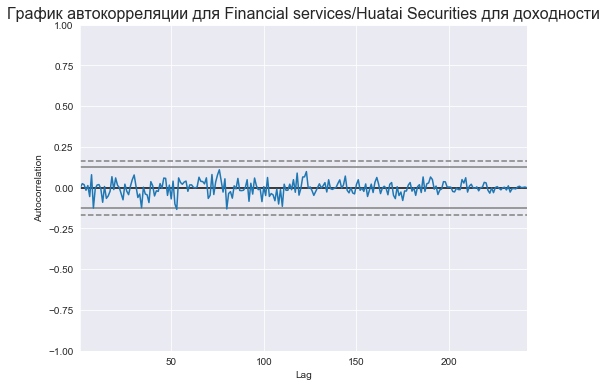

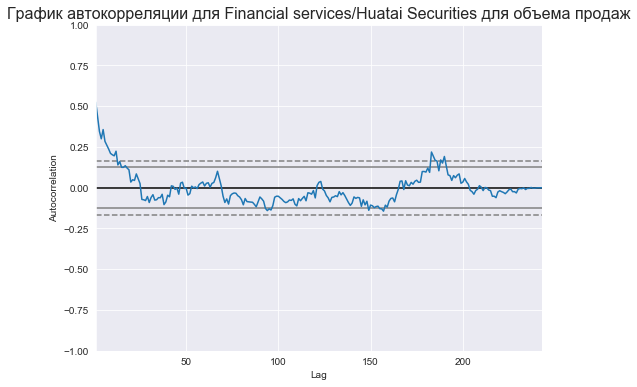

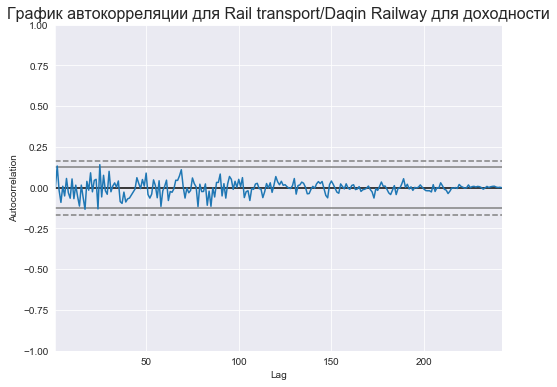

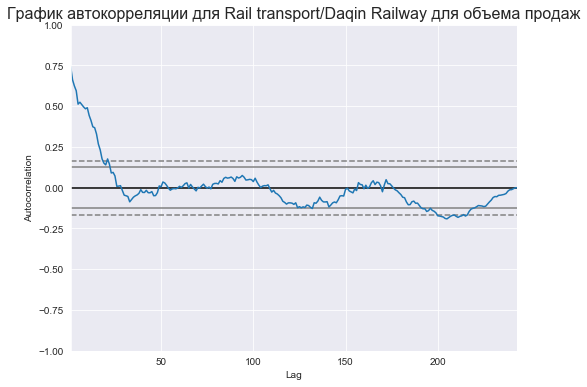

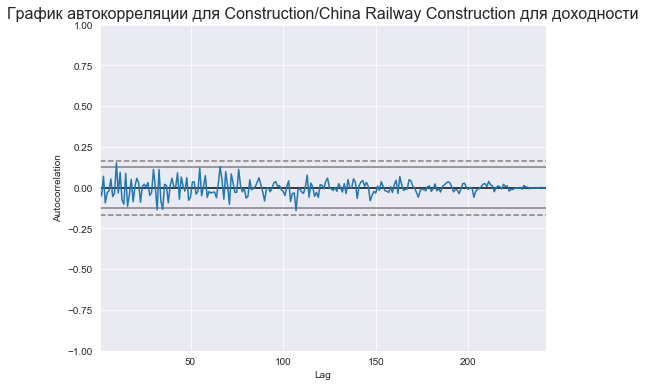

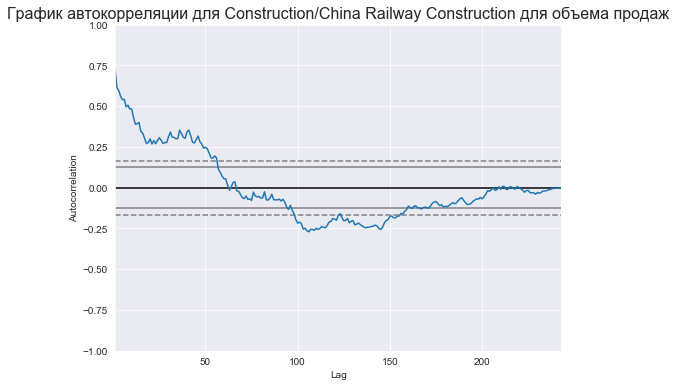

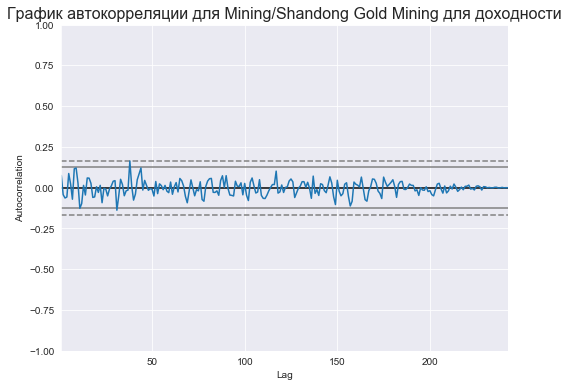

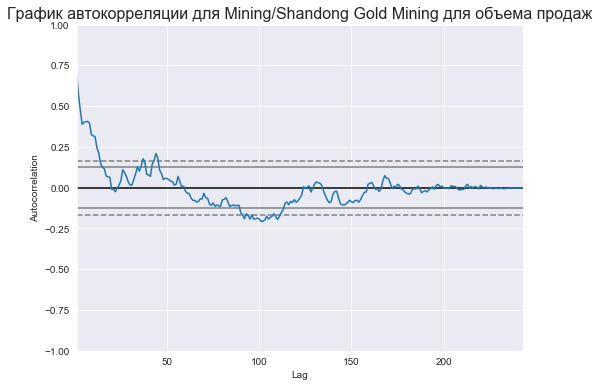

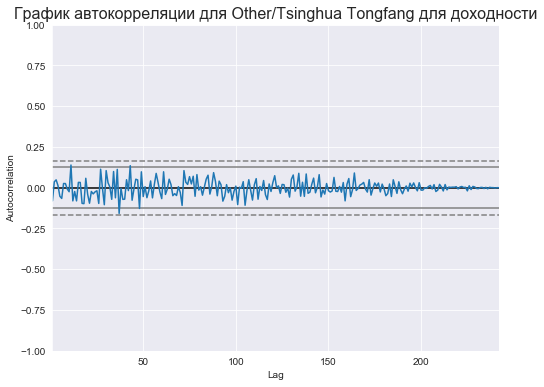

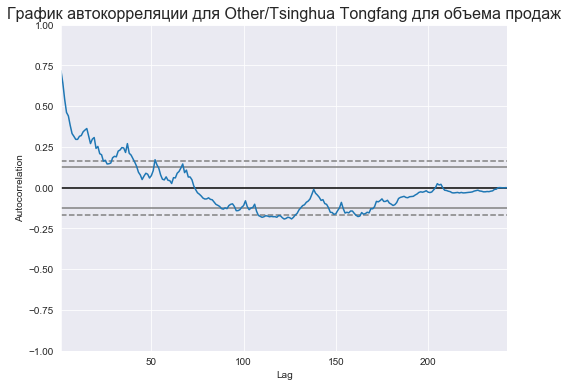

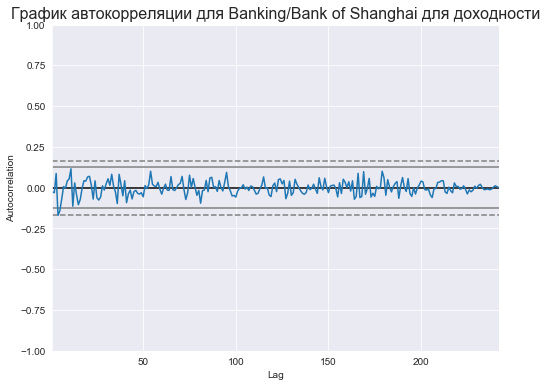

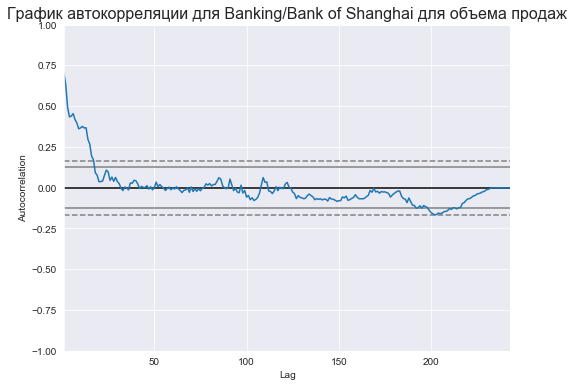

In [ ]:
from pandas.plotting import autocorrelation_plot
start = "\033[1m"
end = "\033[0;0m"
alpha = 0.05
for label in stocks_names:
    stock = sse_stocks[label]
    for column in ['log_return','Volume']:
        autocorrelation_test(stock, alpha, label, column)
        plt.figure(figsize=(8,6))
        autocorrelation_plot(stock[column].dropna())
        plt.title(f"График автокорреляции для {label} для {to_rus[column]}", size=16)
    print()

#### Cравнительный анализ мощности критериев

Перед тем как подводить итоги по проверке гипотезы случайности, сравним между собой используемые нами критерии:

Ниже в порядке убывания мощности критерия расположены критерии, используемые в нашей работе.

| №  | Критерий|
| -- |:-------------| 
| 1| Критерий Инверсий | 
| 2| Автокорреляции| 
| 3| Морана|
| 4| Люнга-Бокса|
| 5| Дюффа-Роя|

#### Итог

Список проверяемых активов(выборка):

- Banking/Bank of Jiangsu
- Automotive/SAIC Motor
- Construction/China Railway Construction
- Oil & gas/PetroChina
- Telecommunication/China United Network Communications


По результатам проверки гипотезы о случайности, можно сделать вывод, что данные по доходностям  для всех активов в выборке являются случайными, так как гипотеза принимается всеми критериями, кроме критерия Дюффа-Роя, который отвергает гипотезу о случайности для всех активов в выборке. Но стоит заметить, что как мы указали выше, мощность этого критерия самая маленькая из чего можно сделать вывод, что отвергать гипотезу о случайности на основе него нельзя, при условии  когда при других критериях она принимается.

Мы так же проверил проверку для данных по объему продаж и на ее основе можно сделать вывод, что данные по объему продаж не являются случайными, так как гипотеза отвергается большинством критереев. Исключение состовляет актив **Telecommunication/China United Network Communications**, для него гипотеза принимается по критерию автокорреляций, Морана и Люнга Бокса и отвергается критерием инверсий и Дюффа-Роя, но отсылаясь к замечению  о мощностях критериев, мы можем сделать вывод, что гипотеза отвергается, так как критерий инверсий обладает самой высокой мощностью.

In [ ]:
# intresting_ticker = 'Mining/Shandong Gold Mining'
# sse_stocks[intresting_ticker].plot(y='Volume', grid=True, figsize=(16,6))
# plt.title(intresting_ticker+' Volume', size=15)
# pass

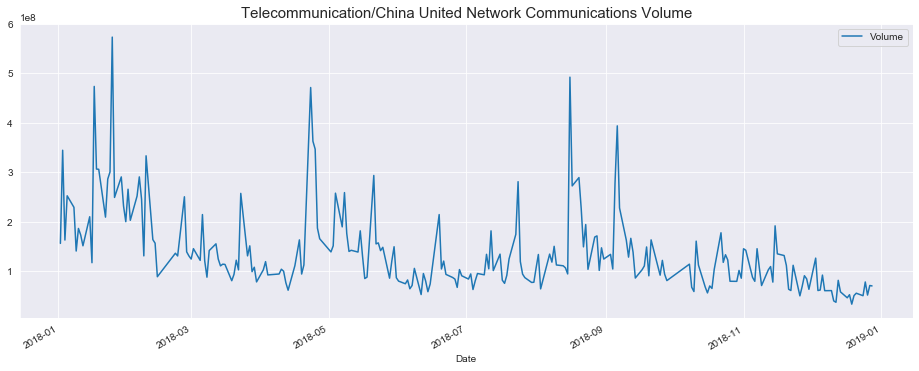

In [ ]:
intresting_ticker = 'Telecommunication/China United Network Communications'
sse_stocks[intresting_ticker].plot(y='Volume', grid=True, figsize=(16,6))
plt.title(intresting_ticker+' Volume', size=15)
pass

<b>7. Выберите несколько интересных (значимых) активов рынка из разных производственных секторов. В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения, исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов. Сделать выводы.

Для отбора значимых активов используется кэффициент sharp-ratio (1966) $S=\frac{R_a - R_f}{\sigma_a}$, где $r_f$ - доходность безрискового актива (взята доходность Национального Банка Китая ($Bank of China Limited$)).

In [ ]:
sse_stat['Sharp'] = (sse_stat['mean_log_return']-sse_stat[sse_stat.industry == 'Risk free']['mean_log_return'].values)
sse_stat['Sharp'] /= sse_stat['sigma']
sse_stat.sort_values(by='Sharp')[-10:]

,sigma,E,names,mean_vol,mean_log_return,industry,Sharp
29,0.022834,-0.000440,Huatai Securities,4.980450e+07,-0.000440,Financial services,0.009472
42,0.015489,-0.000429,Daqin Railway,4.106944e+07,-0.000429,Rail transport,0.014680
13,0.014257,-0.000404,China Everbright Bank,1.007116e+08,-0.000404,Banking,0.017694
14,0.013062,-0.000403,Bank of China,1.560815e+08,-0.000403,Banking,0.019372
16,0.022858,-0.000200,China Railway Construction,4.434866e+07,-0.000200,Construction,0.019945
38,0.022151,-0.000175,Shandong Gold Mining,3.764042e+07,-0.000175,Mining,0.021717
10,0.015387,-0.000277,Agricultural Bank of China,3.317504e+08,-0.000277,Banking,0.024619
11,0.012276,-0.000336,Bank of Communications,9.692052e+07,-0.000336,Banking,0.026111
0,0.023446,-0.000042,Tsinghua Tongfang,1.591310e+07,-0.000042,Other,0.026187
9,0.014521,0.000351,Bank of Shanghai,3.694606e+07,0.000351,Banking,0.069367


Ожидаемо в список самых значимых активов по показателю sharp ratio вошло много банковских компаний (5/10), из этого списка взяты 5 остальных компаний и один банк в качестве значимых активов.

In [ ]:
# Удаляем из топ-10 компаний по sharp-ratio все банки, кроме Bank of Shanghai (максимальный sharp-ratio)

top_sharp_ratio = sse_stat.sort_values(by='Sharp')[-10:]
banking_index = top_sharp_ratio[top_sharp_ratio.industry == 'Banking'].index ^ [top_sharp_ratio['Sharp'].argmax()]
top_sharp_ratio = top_sharp_ratio.drop(banking_index)
stocks_names = list(top_sharp_ratio['industry'] + '/' + top_sharp_ratio['names'])

Сформированный список активов, наиболее интересных к рассмотрению ('Название области/Название компании')

In [ ]:
stocks_names

['Financial services/Huatai Securities',
 'Rail transport/Daqin Railway',
 'Construction/China Railway Construction',
 'Mining/Shandong Gold Mining',
 'Other/Tsinghua Tongfang',
 'Banking/Bank of Shanghai']

Предположим, что доходности выбранных активов имеют нормальное распределение, построим гистограммы доходностей.

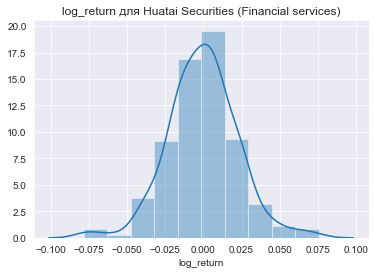

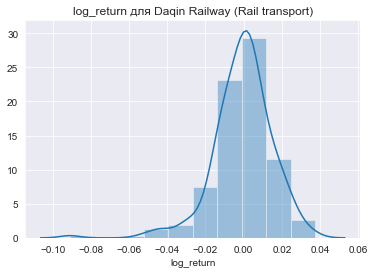

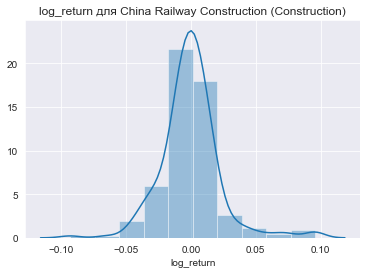

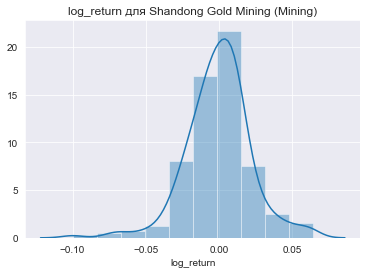

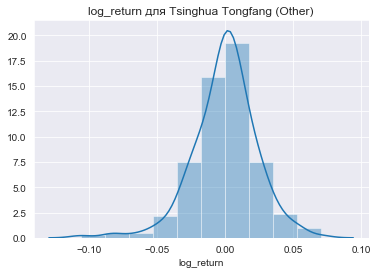

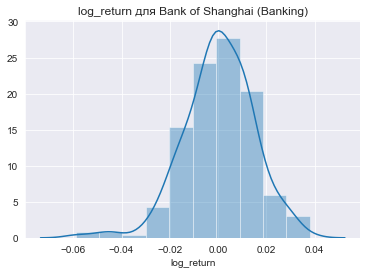

In [ ]:
def plot_vs_pdf(labels, column):
    for label in labels:
        plt.grid()
        sns.distplot(sse_stocks[label][column], bins=10)
        plt.title("{} для {} ({})".format(column, label.split('/')[1], label.split('/')[0]))
        plt.show()
plot_vs_pdf(stocks_names, 'log_return')

По построенным графикам нельзя сделать однозначного вывода, построим тесты для проверки гипотезы о нормальности распределения доходности с уровнем значимости $\alpha = 0.05$. Для тестирования гипотезы будем использовать тесты Шапиро-Вилка, Д'Агостино, Андерсона-Дарлинга

In [ ]:
from scipy.stats import shapiro, normaltest, anderson
tests = {"Shapiro-test" : shapiro, 
         "D'Agostino-test" : normaltest, 
         "Anderson-test" : anderson, }
def test_gipothesys(label, column, alfa=0.05):
    for test_name, test_f in tests.items():
        result = test_f(sse_stocks[label][column].dropna())
        if test_name == 'Anderson-test':
            statistic = result[0]
            answer = 'отклоняется' if statistic > result[1][2] else 'не отвергается'
            print("\t Гипотеза {} {} {} {}, статистика={:3f}".format(start, answer, end, test_name, statistic))
        else:
            p_value = result[1]
            answer = 'не отвергается' if p_value > alfa else 'отклоняется'
            print("\t Гипотеза {} {} {} {}, p-value={:3f}".format(start, answer, end, test_name,  p_value))

In [ ]:
print('Доходности:\n\n')
for label in stocks_names:
    print("Для {}:".format(label))
    test_gipothesys(label, column='log_return')

Доходности:


Для Financial services/Huatai Securities:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.010963
	 Гипотеза  отклоняется  D'Agostino-test, p-value=0.014842
	 Гипотеза  не отвергается  Anderson-test, статистика=0.743349
Для Rail transport/Daqin Railway:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.000000
	 Гипотеза  отклоняется  D'Agostino-test, p-value=0.000000
	 Гипотеза  отклоняется  Anderson-test, статистика=2.254617
Для Construction/China Railway Construction:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.000000
	 Гипотеза  отклоняется  D'Agostino-test, p-value=0.000000
	 Гипотеза  отклоняется  Anderson-test, статистика=5.611971
Для Mining/Shandong Gold Mining:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.000005
	 Гипотеза  отклоняется  D'Agostino-test, p-value=0.000005
	 Гипотеза  отклоняется  Anderson-test, статистика=2.036096
Для Other/Tsinghua Tongfang:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.000008
	 Гипотеза  отклоняется  D'Agostino-test, p-

Гипотеза о нормальности распределения доходностей не подтвердилась, тесты опровергли гипотезу о нормальности. Для двух активов: Financial services/Huatai Securities и Banking/Bank of Shanghai по тесту Андерсона гипотеза о нормальности не отвергается.

Сделаем аналогичное предположение по поводу объёма продаж.

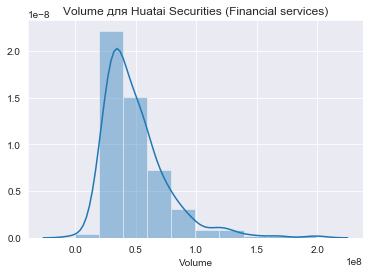

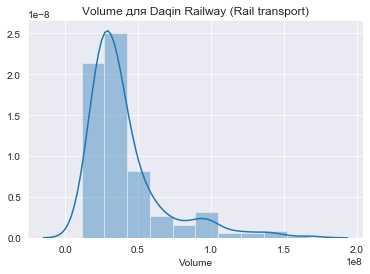

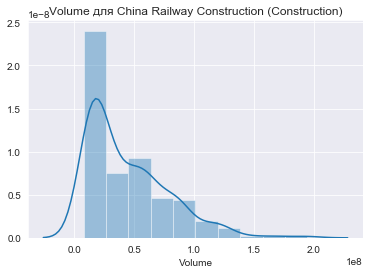

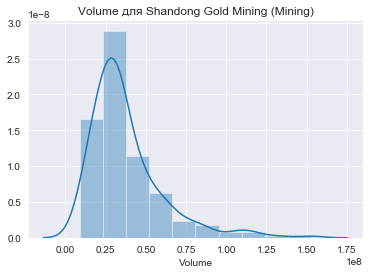

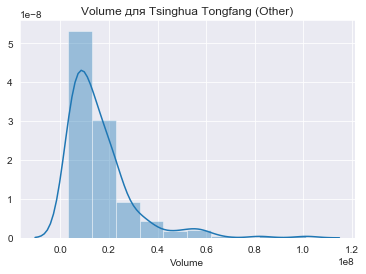

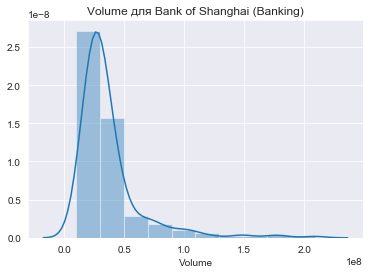

In [ ]:
plot_vs_pdf(stocks_names, 'Volume')

In [ ]:
print('Объем продаж:\n\n')
for label in stocks_names:
    print("Для {}:".format(label))
    test_gipothesys(label, column='Volume')

Объем продаж:


Для Financial services/Huatai Securities:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.000000
	 Гипотеза  отклоняется  D'Agostino-test, p-value=0.000000
	 Гипотеза  отклоняется  Anderson-test, статистика=9.272374
Для Rail transport/Daqin Railway:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.000000
	 Гипотеза  отклоняется  D'Agostino-test, p-value=0.000000
	 Гипотеза  отклоняется  Anderson-test, статистика=18.676122
Для Construction/China Railway Construction:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.000000
	 Гипотеза  отклоняется  D'Agostino-test, p-value=0.000000
	 Гипотеза  отклоняется  Anderson-test, статистика=9.349457
Для Mining/Shandong Gold Mining:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.000000
	 Гипотеза  отклоняется  D'Agostino-test, p-value=0.000000
	 Гипотеза  отклоняется  Anderson-test, статистика=10.781806
Для Other/Tsinghua Tongfang:
	 Гипотеза  отклоняется  Shapiro-test, p-value=0.000000
	 Гипотеза  отклоняется  D'Agostino-test, p

Объём продаж выбранных активов также не имеет нормального распределения.

Рассмотрим 2 актива: 'Financial services/Huatai Securities', 'Banking/Bank of Shanghai'.<br>
Эти два актива принадлежат двум смежным сферам - сфера фин. сервисов и банковская сфера.

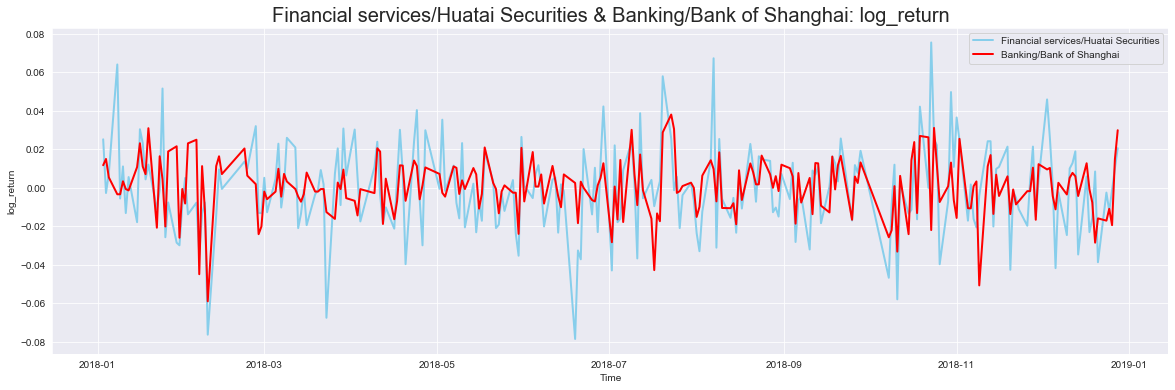

In [ ]:
from matplotlib.pyplot import figure


def plot_2_stock(labels, y):
    stock1, names1 = sse_stocks[labels[0]], [labels[0]] * len(sse_stocks[labels[0]])
    stock2, names2 = sse_stocks[labels[1]], [labels[1]] * len(sse_stocks[labels[1]])
    y1 = sse_stocks[labels[0]][y]
    y2 = sse_stocks[labels[1]][y]
    x = sse_stocks[labels[0]].index.values
    
    figure(figsize=(20, 6))
    plt.grid()
    plt.plot(x, y1, marker='', color='skyblue', linewidth=2, label=labels[0])
    plt.plot(x, y2, marker='', color='red', linewidth=2, label=labels[1])
    plt.xlabel('Time')
    plt.ylabel(y)
    plt.legend()
    plt.title(' & '.join(labels)+': '+y, size=20)

    
plot_2_stock(['Financial services/Huatai Securities', 'Banking/Bank of Shanghai'], 'log_return')

Из графика видно, что логарифмические доходности обоих активов ведут себя похожим образом.Т.е повышение и снижение доходностей происходит в одно и то же время. <br>
Также можно отметить, что акции Bank of Shanghai показывают более стабильное поведение, достигая своего наименьшего (-0.05) и наибольшего (0.04) значений в более узком диапазоне, чем это делает Huatai Securities (-0.08) и (0.08) соответственно. Такую "стабильность" актива Bank of Shaghai можно объяснить тем, что этот банк является компанией, которая имеет одну из самых высоких доходностей в списке SSE50 и риск на уровне индекса рынка. В некотором смысле, этот актив можно считать безрисковым. 

<Figure size 1152x576 with 0 Axes>

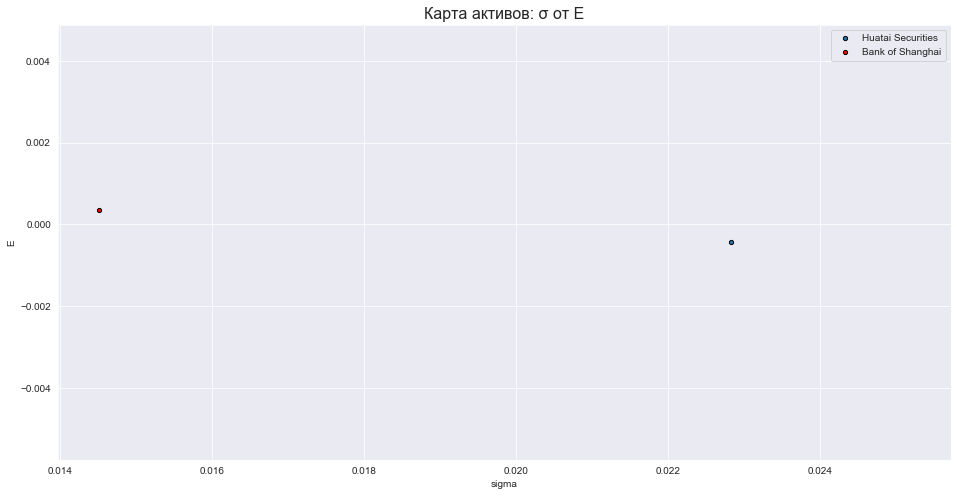

In [ ]:
plt.figure(figsize=(16, 8))
stock1 = sse_stat[sse_stat.names == 'Huatai Securities']
stock2 = sse_stat[sse_stat.names == 'Bank of Shanghai']
ax = stock1.plot(x='sigma', y='E', s=np.log(stock1['mean_vol']), 
                      kind='scatter', 
                      figsize=(16, 8), 
                      edgecolor='black',
                      label='Huatai Securities')
stock2.plot(x='sigma', y='E', s=np.log(stock2['mean_vol']), kind='scatter',  
               edgecolor='black',  
               grid=True, 
               c='red', 
               ax=ax, 
               label='Bank of Shanghai')
plt.title("Карта активов: σ от E", size=16)
pass

Построив карту активов можно увидеть, что при сравнимом уровне объёмов продаж (размер точки) банк обладает низким риском (большей стабильностью активов), что и подтвердилось на графике (Time, Log_R)

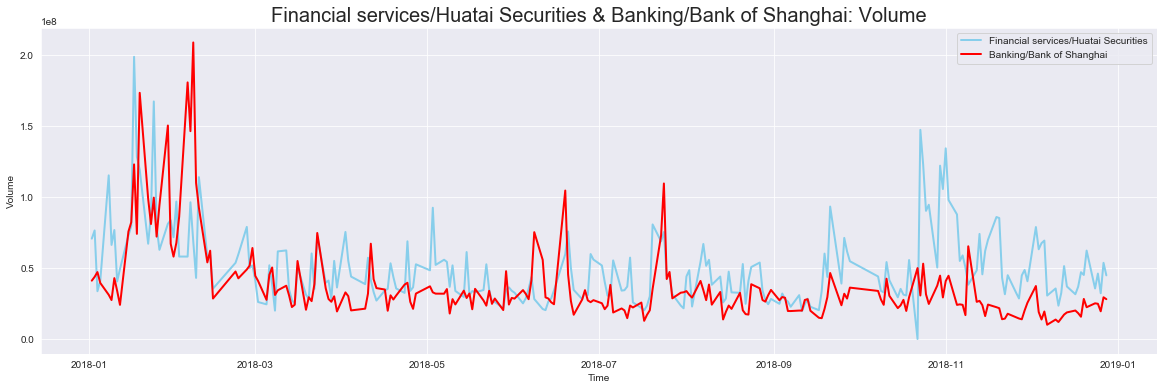

In [ ]:
plot_2_stock(['Financial services/Huatai Securities', 'Banking/Bank of Shanghai'], 'Volume')

Про зависимость объёмов продаж "Volume" можно сказать, что оба актива подчиняются одному тренду, если рассмотреть пиковые состояния - они имеют одинаковые направленности: "взлёты" и "падения" происходят в одни и те же моменты времени. Как пример, Янв-Фев 2018 - является временным отрезком, в который объёмы продаж обеих компаний максимальны. Такую специфику поведения можно объяснить тем, что активы относятся к одной сфере - сфере финансов.
- На графике видны пиковые объёмы продаж: 17 января 2018 г. для Huatai Securities, по данным службы информации РИА «Новый День»: "Эксперты связывают резкое падение стоимости криптоволют с введением регулирования рынка криптовалют, а также уходом мелких инвесторов, которые надеялись на колоссальную прибыль. Эксперты, опрошенные РБК, связали такую высокую волатильность с разочарованием мелких инвесторов. Вероятно, те, кто вложился в биткоин, надеялись на повторение декабрьских достижений, тогда курс криптовалюты перевалил за 20 тысяч долларов." [Источник](https://newdaynews.ru/economy/625593.html)
- Если рассмотреть дату 7 февраля 2018 года, когда Bank of Shaghai имел самый высокий объём продаж, то можно найти два события, которые произошли в этот день в Китае: [землетрясение на Тайване](https://www.interfax.ru/world/598966) и открытие перекрестных ["Годов межрегионального сотрудничества России и Китая" (6-7 февраля)](https://rg.ru/2018/02/07/reg-dfo/chzhan-cinvej-my-prodvinem-sotrudnichestvo-knr-i-rf-na-novyj-uroven.html)

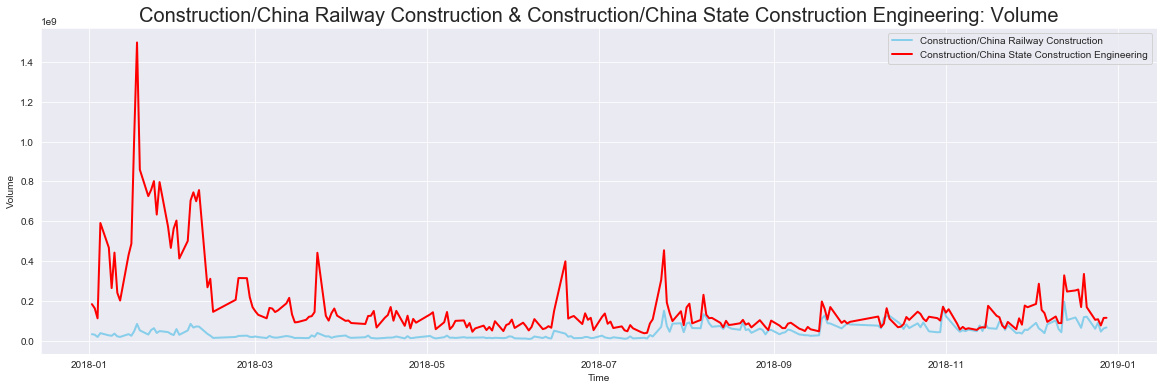

In [ ]:
plot_2_stock(['Construction/China Railway Construction', 
              'Construction/China State Construction Engineering'], 
             'Volume')

На данном графике видно, что события 18.01.2018 отразилась и на компании Construction/China State Construction Engineering - это крупнейшая строительная компания Китая, вероятно, это последствия урегулирования рынка криптоволют.

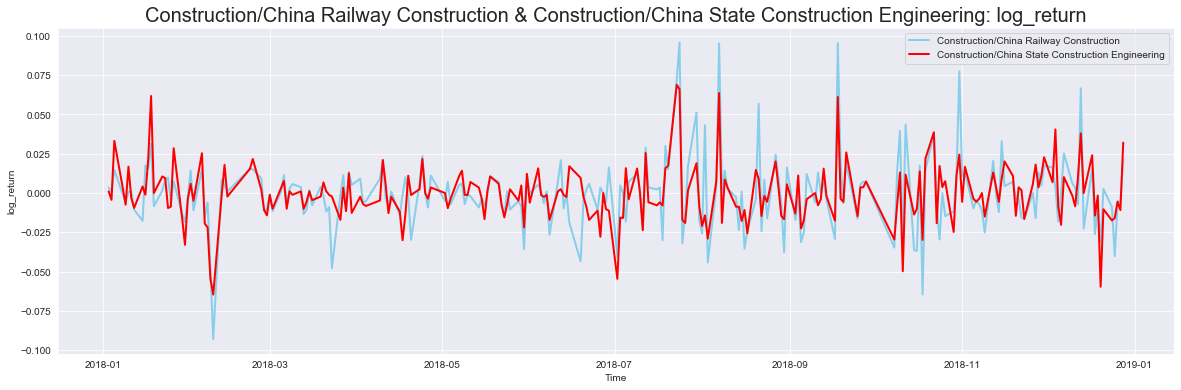

In [ ]:
plot_2_stock(['Construction/China Railway Construction', 
              'Construction/China State Construction Engineering'], 
             'log_return')

На данном графие видно, что доходность обеих компаний упала через день после открытия "годов межрегионального сотрудничества России и Китая, которые проводятся в 2018-2019 годах". Это может быть связано с открытием Международных транспортных коридоров: Приморье-1/2. Приморье-2 - это маршрут поставки грузов Россия-Китай, заключение сотрудничества Китая и России, который подразумевает обновление инфраструктуры и обслуживание ж/д.

<b>8. Исследовать зависимости (выборочно) между доходностями различных активов с помощью техники анализа зависимостей. Сделайте анализ зависимостей между парами активов для активов из одного производственного сектора и для активов из разных производственных секторов. Сделайте анализ зависимости (выборочно) между доходностями и объемами продаж одного актива. Рассмотрите активы из разных производственных секторов.

Для того чтобы понять есть ли зависимость между случайными величинами, нам нужно посчитать корреляцию между ними.

In [ ]:
# !pip install prettytable
from prettytable import PrettyTable

def generate_ascii_table(df):
    x = PrettyTable()
    x.field_names = df.columns.tolist()
    for row in df.values:
        x.add_row(row)
    print(x)
    return x

class CorrelationReporter:
    def __init__(self,stocks):
        self.stocks = stocks
        
    def get_corr_pd(self, stock1, stock2, keys):
        return pd.concat([stock1, stock2], axis=1, sort=False, keys=keys)
    
    def scatter_draw(self, stock1, stock2, keys):
        plt.grid()
        plt.scatter(stock1, stock2,c = 'blue', edgecolors='black')
        plt.xlabel(keys[0])
        plt.ylabel(keys[1])
        
    def __call__(self, label1, label2, value,value_2=None):
        if value_2 is None:
            stock1 = self.stocks[label1][value].dropna()
            stock2 = self.stocks[label2][value].dropna()
            keys = [label1, label2]
        else:
            stock1 = self.stocks[label1][value].dropna()
            stock2 = self.stocks[label2][value_2].dropna()
            keys = [value, value_2]
            
        if stock1.shape != stock2.shape:
            new_size = stock1.shape[0]
            stock1 = stock1[:new_size]
            stock2 = stock2[:new_size]
            
        concat_pd = self.get_corr_pd(stock1, stock2, keys)
        corr = concat_pd.corr()
        corr_value = np.corrcoef(stock1,stock2)[0][1]
        self.scatter_draw(stock1,stock2,keys)
        plt.title(label1+' & '+label2, size=15)
        plt.show()
        generate_ascii_table(corr)
        if value_2 is None:
            print(f'Коэфф. корреляции  между {label1} и {label2} по {value} равен {round(corr_value, 3)}')
        else:
            print(f'Коэфф. корреляции  между {label1} {value} и {label1} {value_2}  равен {round(corr_value, 3)}')

#### Теперь рассмотрим корреляцию на наших данных.

Активы используются из задания 7.

- Financial services/Huatai Securities'
- Rail transport/Daqin Railway'
- Construction/China Railway Construction'
- Mining/Shandong Gold Mining'
- Other/Tsinghua Tongfang'
- Banking/Bank of Shanghai'

#### Анализ зависимости доходностей у активов из одного производственного сектора:

#### Banking

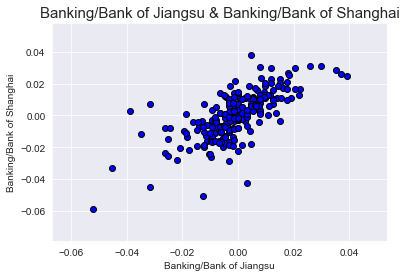

+-------------------------+--------------------------+
| Banking/Bank of Jiangsu | Banking/Bank of Shanghai |
+-------------------------+--------------------------+
|           1.0           |    0.7027431203952196    |
|    0.7027431203952196   |           1.0            |
+-------------------------+--------------------------+
Коэфф. корреляции  между Banking/Bank of Jiangsu и Banking/Bank of Shanghai по log_return равен 0.703


In [ ]:
corr_reporter = CorrelationReporter(sse_stocks)
corr_reporter('Banking/Bank of Jiangsu','Banking/Bank of Shanghai', 'log_return')

Коэфициент корреляции 0.70 говорит о достаточно сильной линейной зависимости, которую можно заметить на графике. 

Актив **Banking/Bank of Jiangsu** и **Banking/Bank of Shanghai** из банкирского производственного сектора **зависимы** между собой.


#### Energy

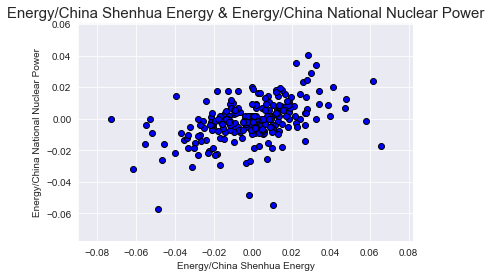

+-----------------------------+-------------------------------------+
| Energy/China Shenhua Energy | Energy/China National Nuclear Power |
+-----------------------------+-------------------------------------+
|             1.0             |          0.439908101495939          |
|      0.439908101495939      |                 1.0                 |
+-----------------------------+-------------------------------------+
Коэфф. корреляции  между Energy/China Shenhua Energy и Energy/China National Nuclear Power по log_return равен 0.44


In [ ]:
corr_reporter('Energy/China Shenhua Energy' , 'Energy/China National Nuclear Power', 'log_return')

Коэфициент корреляции 0.43 является положительной корреляцией, что говорит о прямой зависимости двух активов. 

Актив **Energy/China Shenhua Energy** и **Energy/China National Nuclear Power** из энергетического производственного сектора **зависимы** между собой.

#### Анализ зависимости объема продаж с доходностями у одного актива

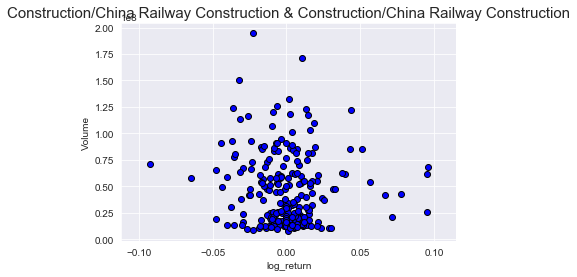

+---------------------+---------------------+
|      log_return     |        Volume       |
+---------------------+---------------------+
|         1.0         | 0.27695173557642705 |
| 0.27695173557642705 |         1.0         |
+---------------------+---------------------+
Коэфф. корреляции  между Construction/China Railway Construction log_return и Construction/China Railway Construction Volume  равен -0.065


In [ ]:
corr_reporter('Construction/China Railway Construction' , 
              'Construction/China Railway Construction', 'log_return', 'Volume')

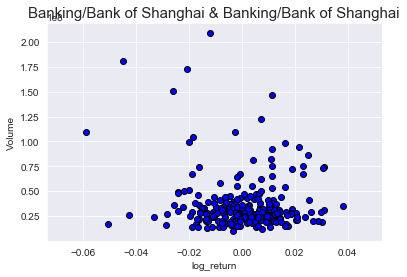

+---------------------+---------------------+
|      log_return     |        Volume       |
+---------------------+---------------------+
|         1.0         | 0.14762482144540262 |
| 0.14762482144540262 |         1.0         |
+---------------------+---------------------+
Коэфф. корреляции  между Banking/Bank of Shanghai log_return и Banking/Bank of Shanghai Volume  равен -0.123


In [ ]:
corr_reporter('Banking/Bank of Shanghai' , 'Banking/Bank of Shanghai', 'log_return', 'Volume')

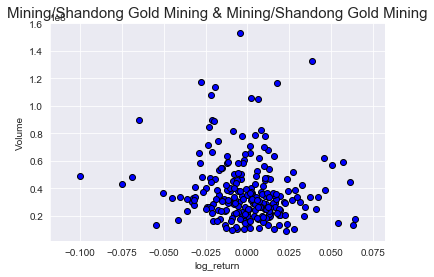

+---------------------+---------------------+
|      log_return     |        Volume       |
+---------------------+---------------------+
|         1.0         | 0.19955882436155534 |
| 0.19955882436155534 |         1.0         |
+---------------------+---------------------+
Коэфф. корреляции  между Mining/Shandong Gold Mining log_return и Mining/Shandong Gold Mining Volume  равен -0.116


In [ ]:
corr_reporter('Mining/Shandong Gold Mining', 'Mining/Shandong Gold Mining', 'log_return', 'Volume')

Коэффициент корреляции отрицательный и близок к нулю, что говорит об отсутствие зависимости между доходностями и объемом продаж  у активов.

#### Анализ зависимости доходностей у активов из разных производственных секторов

#### Energy & Banking

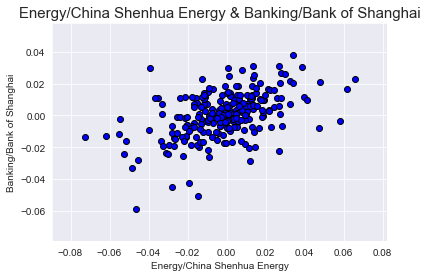

+-----------------------------+--------------------------+
| Energy/China Shenhua Energy | Banking/Bank of Shanghai |
+-----------------------------+--------------------------+
|             1.0             |    0.4859425677282898    |
|      0.4859425677282898     |           1.0            |
+-----------------------------+--------------------------+
Коэфф. корреляции  между Energy/China Shenhua Energy и Banking/Bank of Shanghai по log_return равен 0.486


In [ ]:
corr_reporter('Energy/China Shenhua Energy' , 'Banking/Bank of Shanghai', 'log_return')

Коэфициент корреляции 0.49 говорит о наличие  линейной зависимости, которую можно заметить на графике. 

Актив **Energy/China Shenhua Energy** и **'Banking/Bank of Shanghai'** из из разных производственных секторов **зависимы** между собой. Это может быть обусловлено влиянием сфер друг на друга или же наличием общих внешних факторов.

#### **Automotive & Banking**

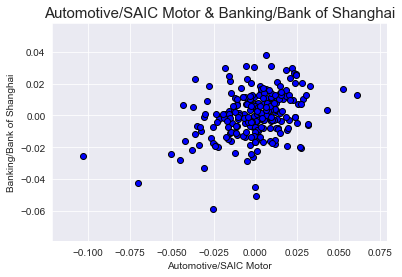

+-----------------------+--------------------------+
| Automotive/SAIC Motor | Banking/Bank of Shanghai |
+-----------------------+--------------------------+
|          1.0          |   0.36529080431102295    |
|  0.36529080431102295  |           1.0            |
+-----------------------+--------------------------+
Коэфф. корреляции  между Automotive/SAIC Motor и Banking/Bank of Shanghai по log_return равен 0.365


In [ ]:
corr_reporter('Automotive/SAIC Motor' , 'Banking/Bank of Shanghai', 'log_return')

Коэфициент корреляции 0.36 говорит о наличие линейной зависимости. 

Актив **Automotive/SAIC Motor** и **Banking/Bank of Shanghai** из разных производственных секторов **зависимы** между собой.

#### Rail transport & Construction

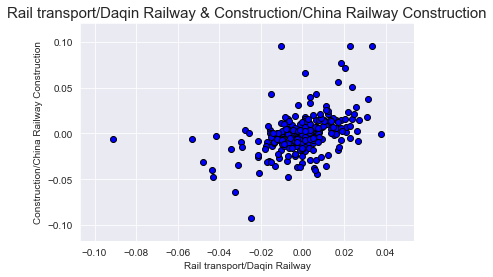

+------------------------------+-----------------------------------------+
| Rail transport/Daqin Railway | Construction/China Railway Construction |
+------------------------------+-----------------------------------------+
|             1.0              |           0.43014312418539563           |
|     0.43014312418539563      |                   1.0                   |
+------------------------------+-----------------------------------------+
Коэфф. корреляции  между Rail transport/Daqin Railway и Construction/China Railway Construction по log_return равен 0.43


In [ ]:
corr_reporter('Rail transport/Daqin Railway' , 'Construction/China Railway Construction', 'log_return')

Коэфициент корреляции 0.43 говорит о наличие  линейной зависимости.

Актив **Rail transport/Daqin Railway** и **Construction/China Railway Construction** из разных производственных секторов **зависимы** между собой. Это объяснимо тем, что хотя производственные секторы и разные, тематически компании свзяаны между собой.

<b>9. Бонус. Попробуйте найти что-нибудь интересное (необычное) на вашем рынке. Используйте любые известные вам методы анализа данных (data mining).

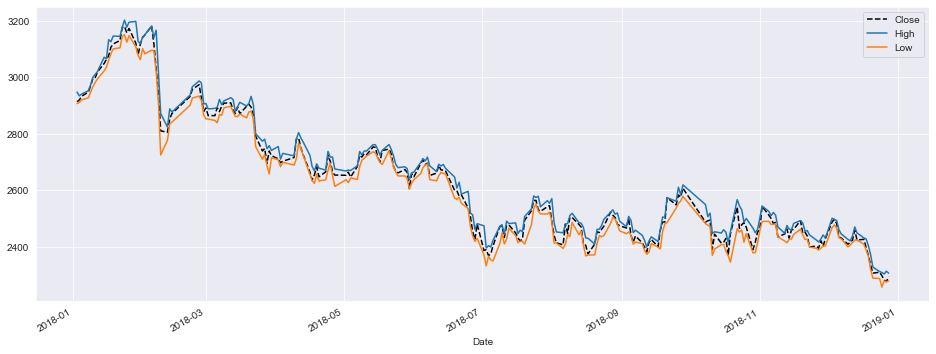

In [ ]:
ax = sse50.plot(y='Close', grid=True, figsize=(16,6), style='k--')
sse50.plot(y='High', grid=True, figsize=(16,6), ax=ax)
sse50.plot(y='Low', grid=True, figsize=(16,6), ax=ax)
plt.show()

[*********************100%***********************]  1 of 1 completed


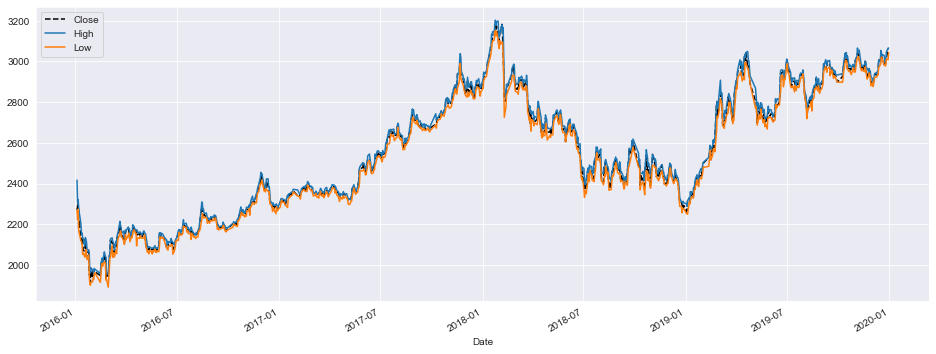

In [ ]:
sse50_2017 = yf.download('^SSE50', start='2016-01-01', end='2020-01-01', progress=True)
ax = sse50_2017.plot(y='Close', grid=True, figsize=(16,6), style='k--')
sse50_2017.plot(y='High', grid=True, figsize=(16,6), ax=ax)
sse50_2017.plot(y='Low', grid=True, figsize=(16,6), ax=ax)
plt.show()

In [ ]:
loss = (1 - sse50['Close'].iloc[-10:-1].mean() / sse50['Close'].iloc[0:10].mean()) * 100
print('Фондовый рынок КНР испытал %.2f%s потерю за 2018 год' %(loss,'%'))

Фондовый рынок КНР испытал 21.31% потерю за 2018 год


**Комментарий**: <br> Китайская экономика считается в последние года самой быстрорастущей, что ожидалось и увидеться в данных по фондовомы рынку Китая за 2018 год. Однако, исходя из данных за 2018 год Китайский рынок ( по индексу SSE50 ) претерпевал постоянные убытки, которые вылились в около 22% потери.
<br>
Такое нетипичное поведение Китайского рынка может быть вызвано двумя [факторами](https://www.cnbc.com/2018/12/31/china-markets-2018-performance-was-worst-in-a-decade.html):

 - продолжающаяся торговая война между Пекином и Вашингтоном
 - Еще до эскалации торговой напряженности с США в этом году Пекин уже пытался справиться с замедлением роста своей экономики после трех десятилетий головокружительного роста.
 

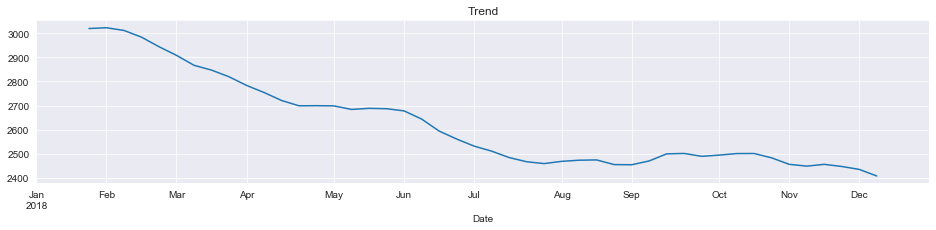

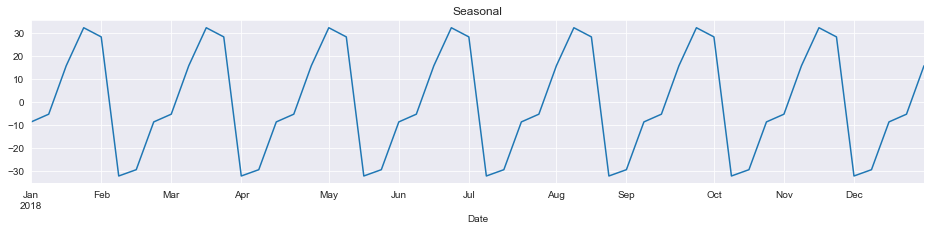

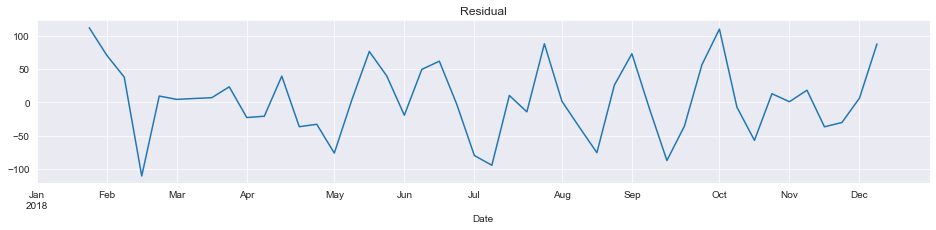

In [ ]:
import statsmodels.api as sm

sse50_month = sse50['Close'].resample('W').mean()
sse50_month = sse50_month.fillna(sse50_month.mean())
# sse50_month.plot(y='Close', grid=True, figsize=(16,6), style='k--', label='Close')

decomposition = sm.tsa.seasonal_decompose(sse50_month, period=7)
plt.figure(figsize=(16,3))
decomposition.trend.plot()
plt.grid()
plt.title('Trend')
plt.show()
plt.figure(figsize=(16,3))
decomposition.seasonal.plot()
plt.grid()
plt.title('Seasonal')
plt.show()
plt.figure(figsize=(16,3))
decomposition.resid.plot()
plt.grid()
plt.title('Residual')
pass


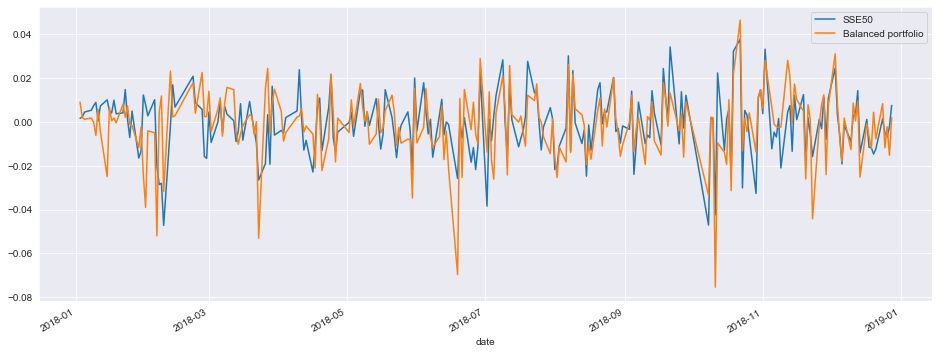

In [ ]:
ax = sse50.plot(y='log_return', grid=True, figsize=(16,6), label='SSE50')
portfolio.plot(y='balanced_log_return', grid=True, figsize=(16,6), ax=ax, label='Balanced portfolio')
plt.show()

In [ ]:
cor = portfolio.corr()

Случайная выборка 20 активов и их корреляция 1


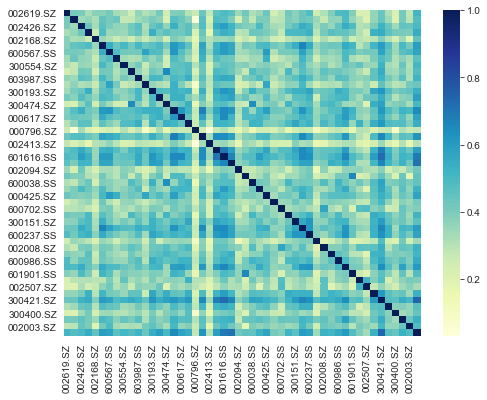

Случайная выборка 20 активов и их корреляция 2


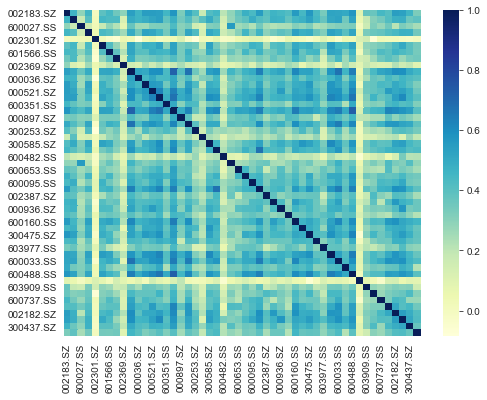

Случайная выборка 20 активов и их корреляция 3


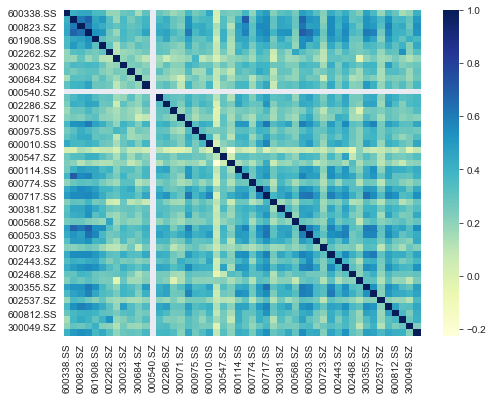

In [ ]:
for i in range(3):
    print('Случайная выборка 20 активов и их корреляция %d' % (i+1))
    sample20 = cor.sample(n=50, axis=0)
    sample20 = sample20[sample20.index]
    plt.figure(figsize=(8,6))
    sns.heatmap(sample20[sample20.index], cmap="YlGnBu")
    plt.show()

In [ ]:
sse_portfolio = pd.DataFrame.from_dict({'date':stocks[symbols[0]].index})
for symbol in list(sse_stocks.keys()):
    try:
        sse_portfolio[symbol] = list(sse_stocks[symbol]['return'])
    except Exception as e:
        continue
sse_portfolio = sse_portfolio.dropna()
sse_portfolio = sse_portfolio.set_index('date')

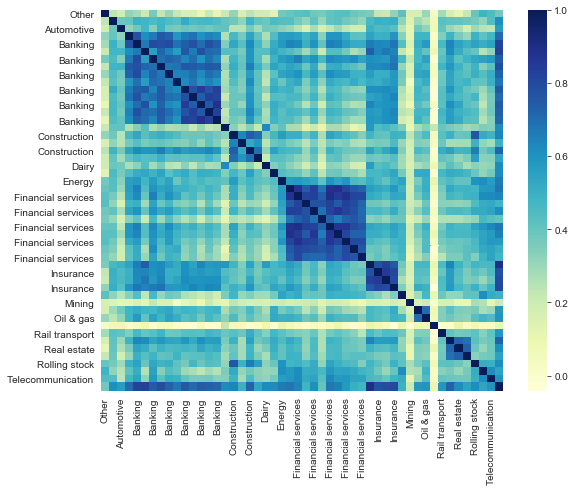

In [ ]:
sse_portfolio.columns = [col[:col.index('/')] for col in sse_portfolio.columns]
sse_cor = sse_portfolio.corr()
plt.figure(figsize=(9,7))
sns.heatmap(sse_cor, cmap="YlGnBu")
plt.show()

**Комментарий**: Можем заметить ожидаемую положительную корреляцию между активами внутри своих секторов.

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)

TODO:
 - сравнить цены с другими годами (2017 и 2019)+
 - оценить темпы падения, угол , скорость,+
 - определить возможно секторы в которых падение сильнее отражено, секторы из-за которых и пошло падение 
 - найти максимальные отрицательные корреляции и попытаться найти объясянение
 - почитать статьи про китайский рынок +
 - прочитать статьи про анализ фондовых рынков на пайтон ( по типу tricks and hints)

<br> Попробуем спрогнозировать цену акций индекса SSE50 в 2018 году по данным 2017 года

Для этого воспоьльзуемся инструментом [prophet (facebook)](https://facebook.github.io/prophet/)


Prophet - `это процедура прогнозирования данных временных рядов на основе аддитивной модели, в которой нелинейные тренды согласуются с годовой, недельной и ежедневной сезонностью плюс праздничные эффекты. Он лучше всего работает с временными рядами, которые имеют сильные сезонные эффекты и несколько сезонов исторических данных. Prophet устойчив к отсутствию данных и сдвигам в тренде и, как правило, хорошо справляется с выбросами.`

[*********************100%***********************]  1 of 1 completed
^SSE50 Stocker Initialized. Data covers 2017-01-03 00:00:00 to 2017-12-29 00:00:00.
Predicted Price on 2018-04-08 00:00:00 = $2901.66


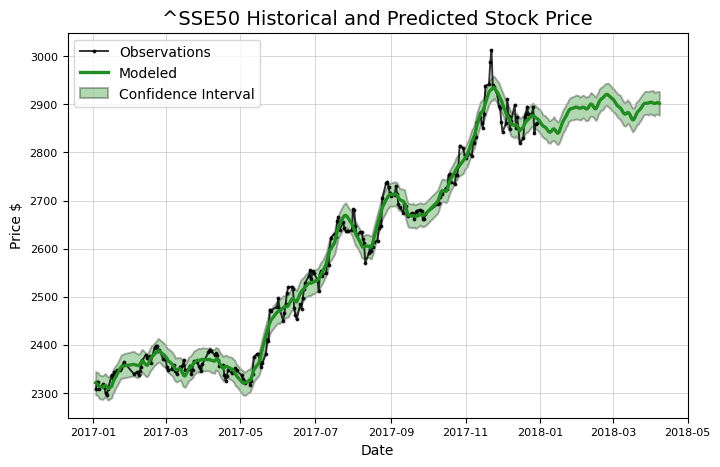

In [3]:
sse_50_2017 = Stocker('^SSE50', "2017-01-01", "2017-12-31")
model, model_data = sse_50_2017.create_prophet_model(days=100)

**Комментарий**: С помощью модели мы можем сделать прогноз на любое количество заданных дней. Прогнозируя цену акций на 100 дней (на основе данных за 2017) вперёд можно заметить, что моделируется замедление роста (2018.01 - 2018.05).

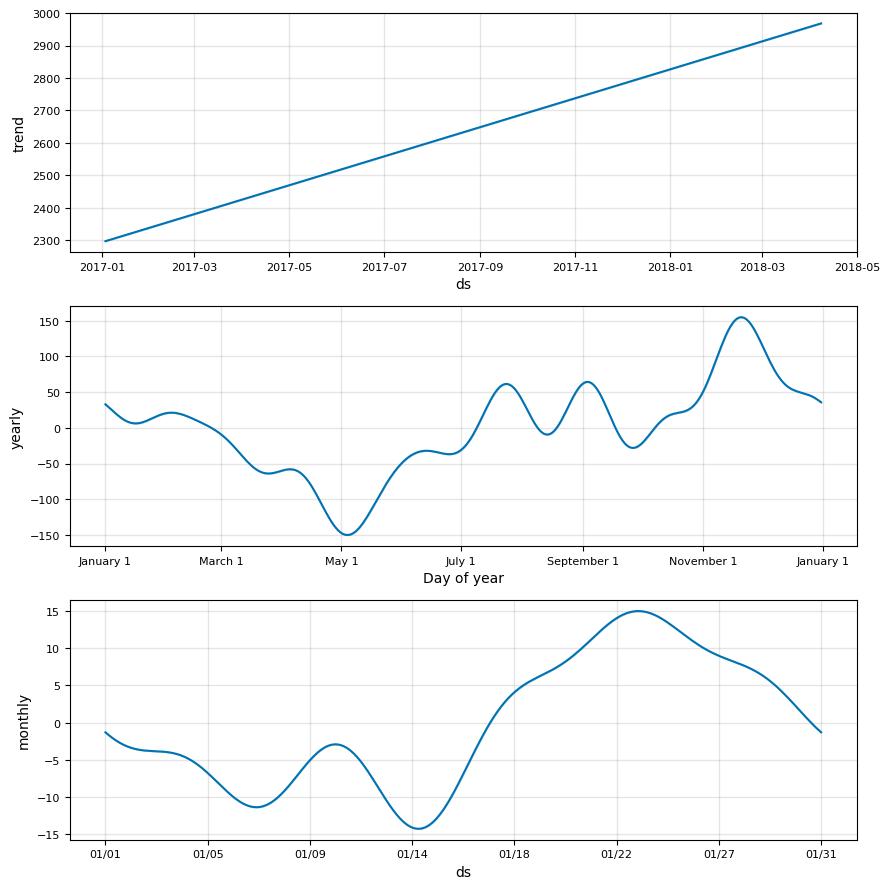

In [4]:
# Variables assigned from previous method call
model.plot_components(model_data)
plt.show()

**Комментарий:** график отражает спрогнозированные моделью тренды, общий тренд (за 2017-2018 год), как и на предыдущем графике обещает возрастание цены акций. Также можем наблюдать за годовыми и месячными трендами, которые отражают изменение цены в течение конкретного промежутка.

Предскажем цены акци на 2018 год на основе даных 2017 года.

[*********************100%***********************]  1 of 1 completed
^SSE50 Stocker Initialized. Data covers 2017-01-03 00:00:00 to 2018-12-28 00:00:00.

Prediction Range: 2017-12-28 00:00:00 to 2018-12-28 00:00:00.

Predicted price on 2018-12-27 00:00:00 = $3432.54.
Actual price on    2018-12-27 00:00:00 = $2276.06.

Average Absolute Error on Training Data = $14.55.
Average Absolute Error on Testing  Data = $520.53.

When the model predicted an increase, the price increased 49.04% of the time.
When the model predicted a  decrease, the price decreased  47.67% of the time.

The actual value was within the 80% confidence interval 6.15% of the time.


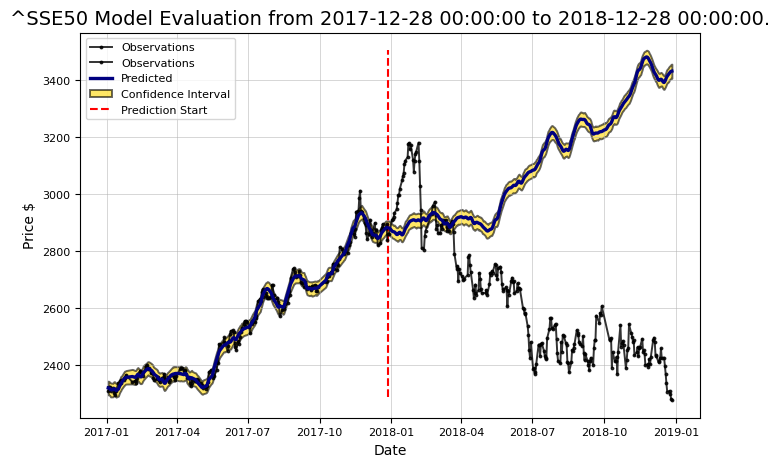

In [5]:
sse_50_hist = Stocker('^SSE50', "2017-01-01", "2019-01-01")
sse_50_hist.evaluate_prediction()

**Комментарий:** по смоделированным данным можем пронаблюдать несостоятельность data-driven подхода перед внешними факторами. Вадим, вам слово.